# 不動産価格予測モデル検討レポート

## 1. はじめに

本レポートでは、米国の特定地域の不動産売買データを用いて、不動産価格予測モデルを構築・評価する。  
本分析は、将来の同様データに対する価格予測サービスの有用性を評価し、事業化の可否や改善策を検討するための基礎資料となる。  

## 2. データ概要

対象データには以下の変数が含まれる。

- **date**: 売買成立日
- **price**: 売買価格(予測対象)
- **sqft_lot**: 敷地面積
- **sqft_living**: 居住スペース面積
- **grade**: 建築・デザイン品質評価(1～13)
- **lat**: 緯度
- **long**: 経度
- **yr_built**: 建築年
- **yr_renovated**: 最終リノベーション年(0は未リノベーション)

本分析では、`date` と `yr_renovated` をモデル利用可能な特徴量へ変換する。

## 3. 分析環境とパッケージ


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%matplotlib inline
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.2f}'.format


## 4. データ読み込みと基本確認

`data.csv` を読み込み、`date` を日付型へ変換する。


In [2]:
# データ読み込み
data = pd.read_csv("data.csv", dtype={'date': str})
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

# 初期データ確認
display(data.head())
display(data.info())


date   price  sqft_lot  sqft_living  grade   lat    long  yr_built  \
0 2014-10-13  221900      5650         1180      7 47.51 -122.26      1955   
1 2014-12-09  538000      7242         2570      7 47.72 -122.32      1951   
2 2015-02-25  180000     10000          770      6 47.74 -122.23      1933   
3 2014-12-09  604000      5000         1960      7 47.52 -122.39      1965   
4 2015-02-18  510000      8080         1680      8 47.62 -122.05      1987   

   yr_renovated  
0             0  
1          1991  
2             0  
3             0  
4             0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          21613 non-null  datetime64[ns]
 1   price         21613 non-null  int64         
 2   sqft_lot      21613 non-null  int64         
 3   sqft_living   21613 non-null  int64         
 4   grade         21613 non-null  int64         
 5   lat           21613 non-null  float64       
 6   long          21613 non-null  float64       
 7   yr_built      21613 non-null  int64         
 8   yr_renovated  21613 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 1.5 MB


None

## 5. 特徴量エンジニアリング

ここで、`date` からの特徴量抽出と `yr_renovated` からの特徴量変換を行う。

- `date` を用いて `year_sold`, `month_sold`, `days_since_2014_01_01` を作成する
- `yr_renovated` を用いて、リノベーション有無フラグ(`renovated_flag`)およびリノベから売却までの経過年数(`years_since_renovation`)を作成する。

その後、統計量を再確認する。

In [3]:
base_date = pd.Timestamp("2014-01-01")
data['year_sold'] = data['date'].dt.year
data['month_sold'] = data['date'].dt.month
data['days_since_2014_01_01'] = (data['date'] - base_date).dt.days + 1

data['renovated_flag'] = (data['yr_renovated'] > 0).astype(int)
data['years_since_renovation'] = np.where(
    data['yr_renovated'] > 0,
    data['year_sold'] - data['yr_renovated'],
    0
)

# モデル用数値カラム
numeric_cols = [
    'price','sqft_lot','sqft_living','grade','lat','long','yr_built',
    'year_sold','month_sold','days_since_2014_01_01','renovated_flag','years_since_renovation'
]

describe_df = data[numeric_cols].describe()

# 表の表記を日本語に変更
describe_df = describe_df.rename(index={
    'count': '件数',
    'mean': '平均',
    'std': '標準偏差',
    'min': '最小',
    '25%': '25%',
    '50%': '中央値',
    '75%': '75%',
    'max': '最大'
})

# カラム名を日本語に変更
describe_df = describe_df.rename(columns={
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
})

describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")
display(describe_df)


C:\Users\rainb\AppData\Local\Temp\ipykernel_25528\1450717754.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")


価格          敷地面積   居住スペース面積 建築・デザイン品質評価         緯度         経度  \
件数       21,613.00     21,613.00  21,613.00   21,613.00  21,613.00  21,613.00   
平均      540,088.14     15,106.97   2,079.90        7.66      47.56    -122.21   
標準偏差    367,127.20     41,420.51     918.44        1.18       0.14       0.14   
最小       75,000.00        520.00     290.00        1.00      47.16    -122.52   
25%     321,950.00      5,040.00   1,427.00        7.00      47.47    -122.33   
中央値     450,000.00      7,618.00   1,910.00        7.00      47.57    -122.23   
75%     645,000.00     10,688.00   2,550.00        8.00      47.68    -122.12   
最大    7,700,000.00  1,651,359.00  13,540.00       13.00      47.78    -121.31   

            建築年        売却年        売却月 2014年1月1日からの日数 リノベーションフラグ リノベーションからの経過年数  
件数    21,613.00  21,613.00  21,613.00      21,613.00  21,613.00      21,613.00  
平均     1,971.01   2,014.32       6.57         302.19       0.04           0.78  
標準偏差      29.37       0.47       3.12         113.05       0.20           4.90  
最小     1,900.00   2,014.00       1.00         122.00       0.00          -1.00  
25%    1,951.00   2,014.00       4.00         203.00       0.00           0.00  
中央値    1,975.00   2,014.00       6.00         289.00       0.00           0.00  
75%    1,997.00   2,015.00       9.00         413.00       0.00           0.00  
最大     2,015.00   2,015.00      12.00         512.00       1.00          80.00

## 5.2 エラーデータの除外とデータ再確認

リノベーションからの経過年数(`years_since_renovation`)が負の値となっているデータは、`yr_renovated` が `year_sold` より後になっているためエラーデータと判断し、除外します。エラーデータを除外した後、再度統計量を表で確認します。


In [4]:
# エラーデータの除外
initial_count = data.shape[0]
data = data[data['years_since_renovation'] >= 0]
filtered_count = data.shape[0]
removed_count = initial_count - filtered_count

print(f"除外前のデータ件数: {initial_count}")
print(f"除外後のデータ件数: {filtered_count}")
print(f"除外したエラーデータの件数: {removed_count}")

# 再度統計量を確認
describe_df = data[numeric_cols].describe()

# 表の表記を日本語に変更
describe_df = describe_df.rename(index={
    'count': '件数',
    'mean': '平均',
    'std': '標準偏差',
    'min': '最小',
    '25%': '25%',
    '50%': '中央値',
    '75%': '75%',
    'max': '最大'
})

# カラム名を日本語に変更
describe_df = describe_df.rename(columns={
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
})

describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")
display(describe_df)


除外前のデータ件数: 21613
除外後のデータ件数: 21607
除外したエラーデータの件数: 6


C:\Users\rainb\AppData\Local\Temp\ipykernel_25528\847938704.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")


価格          敷地面積   居住スペース面積 建築・デザイン品質評価         緯度         経度  \
件数       21,607.00     21,607.00  21,607.00   21,607.00  21,607.00  21,607.00   
平均      540,061.05     15,107.16   2,079.59        7.66      47.56    -122.21   
標準偏差    367,158.09     41,425.79     918.31        1.18       0.14       0.14   
最小       75,000.00        520.00     290.00        1.00      47.16    -122.52   
25%     321,725.00      5,040.00   1,423.50        7.00      47.47    -122.33   
中央値     450,000.00      7,618.00   1,910.00        7.00      47.57    -122.23   
75%     645,000.00     10,687.50   2,550.00        8.00      47.68    -122.12   
最大    7,700,000.00  1,651,359.00  13,540.00       13.00      47.78    -121.31   

            建築年        売却年        売却月 2014年1月1日からの日数 リノベーションフラグ リノベーションからの経過年数  
件数    21,607.00  21,607.00  21,607.00      21,607.00  21,607.00      21,607.00  
平均     1,971.01   2,014.32       6.57         302.22       0.04           0.78  
標準偏差      29.37       0.47       3.12         113.05       0.20           4.90  
最小     1,900.00   2,014.00       1.00         122.00       0.00           0.00  
25%    1,951.00   2,014.00       4.00         203.00       0.00           0.00  
中央値    1,975.00   2,014.00       6.00         289.00       0.00           0.00  
75%    1,997.00   2,015.00       9.00         413.00       0.00           0.00  
最大     2,015.00   2,015.00      12.00         512.00       1.00          80.00

# 5.3 極端なデータの除外

1. 建築年 (yr_built) の異常値の検出と処理
問題点:

最小値が 1,900 年となっており、非常に古い物件が含まれています。これらの物件は市場特性が異なる可能性があります。
対応策:

戦後時期までに建築された物件は通常の物件とは特性が異なる(歴史的価値など)ものとして、
建築年を 1950年 から 2024年 の間に制限します。

c:\Users\rainb\Projects\DeNA_dataScience\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rainb\Projects\DeNA_dataScience\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rainb\Projects\DeNA_dataScience\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24314 (\N{CJK UNIFIED IDEOGRAPH-5EFA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rainb\Projects\DeNA_dataScience\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31689 (\N{CJK UNIFIED IDEOGRAPH-7BC9}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rainb\Projects\DeNA_dataScience\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarn

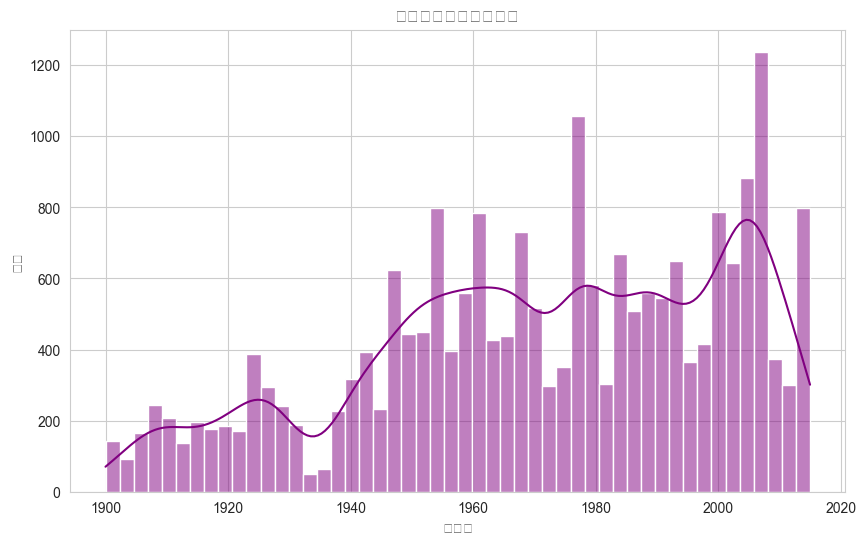

建築年の異常値除外前のデータ件数: 21607
建築年の異常値除外後のデータ件数: 16674
除外した建築年の異常値の件数: 4933


In [5]:
# 建築年の分布を確認
plt.figure(figsize=(10, 6))
sns.histplot(data['yr_built'], bins=50, kde=True, color='purple')
plt.title("建築年のヒストグラム")
plt.xlabel("建築年")
plt.ylabel("件数")
plt.show()

# 建築年の範囲を設定
lower_bound_yr_built = 1950
upper_bound_yr_built = 2024
initial_count = data.shape[0]
data = data[(data['yr_built'] >= lower_bound_yr_built) & (data['yr_built'] <= upper_bound_yr_built)]
filtered_count = data.shape[0]
removed_count = initial_count - filtered_count

print(f"建築年の異常値除外前のデータ件数: {initial_count}")
print(f"建築年の異常値除外後のデータ件数: {filtered_count}")
print(f"除外した建築年の異常値の件数: {removed_count}")


## 5.3 カスタム `whis` による箱ひげ図の表示

このセクションでは、指定した各列に対してカスタム `whis` パラメータを用いた箱ひげ図を表示し、上下限値を計算します。計算された上限値は後続のデータフィルタリングで使用します。

### スクリプト1: 箱ひげ図の表示と上下限値の計算


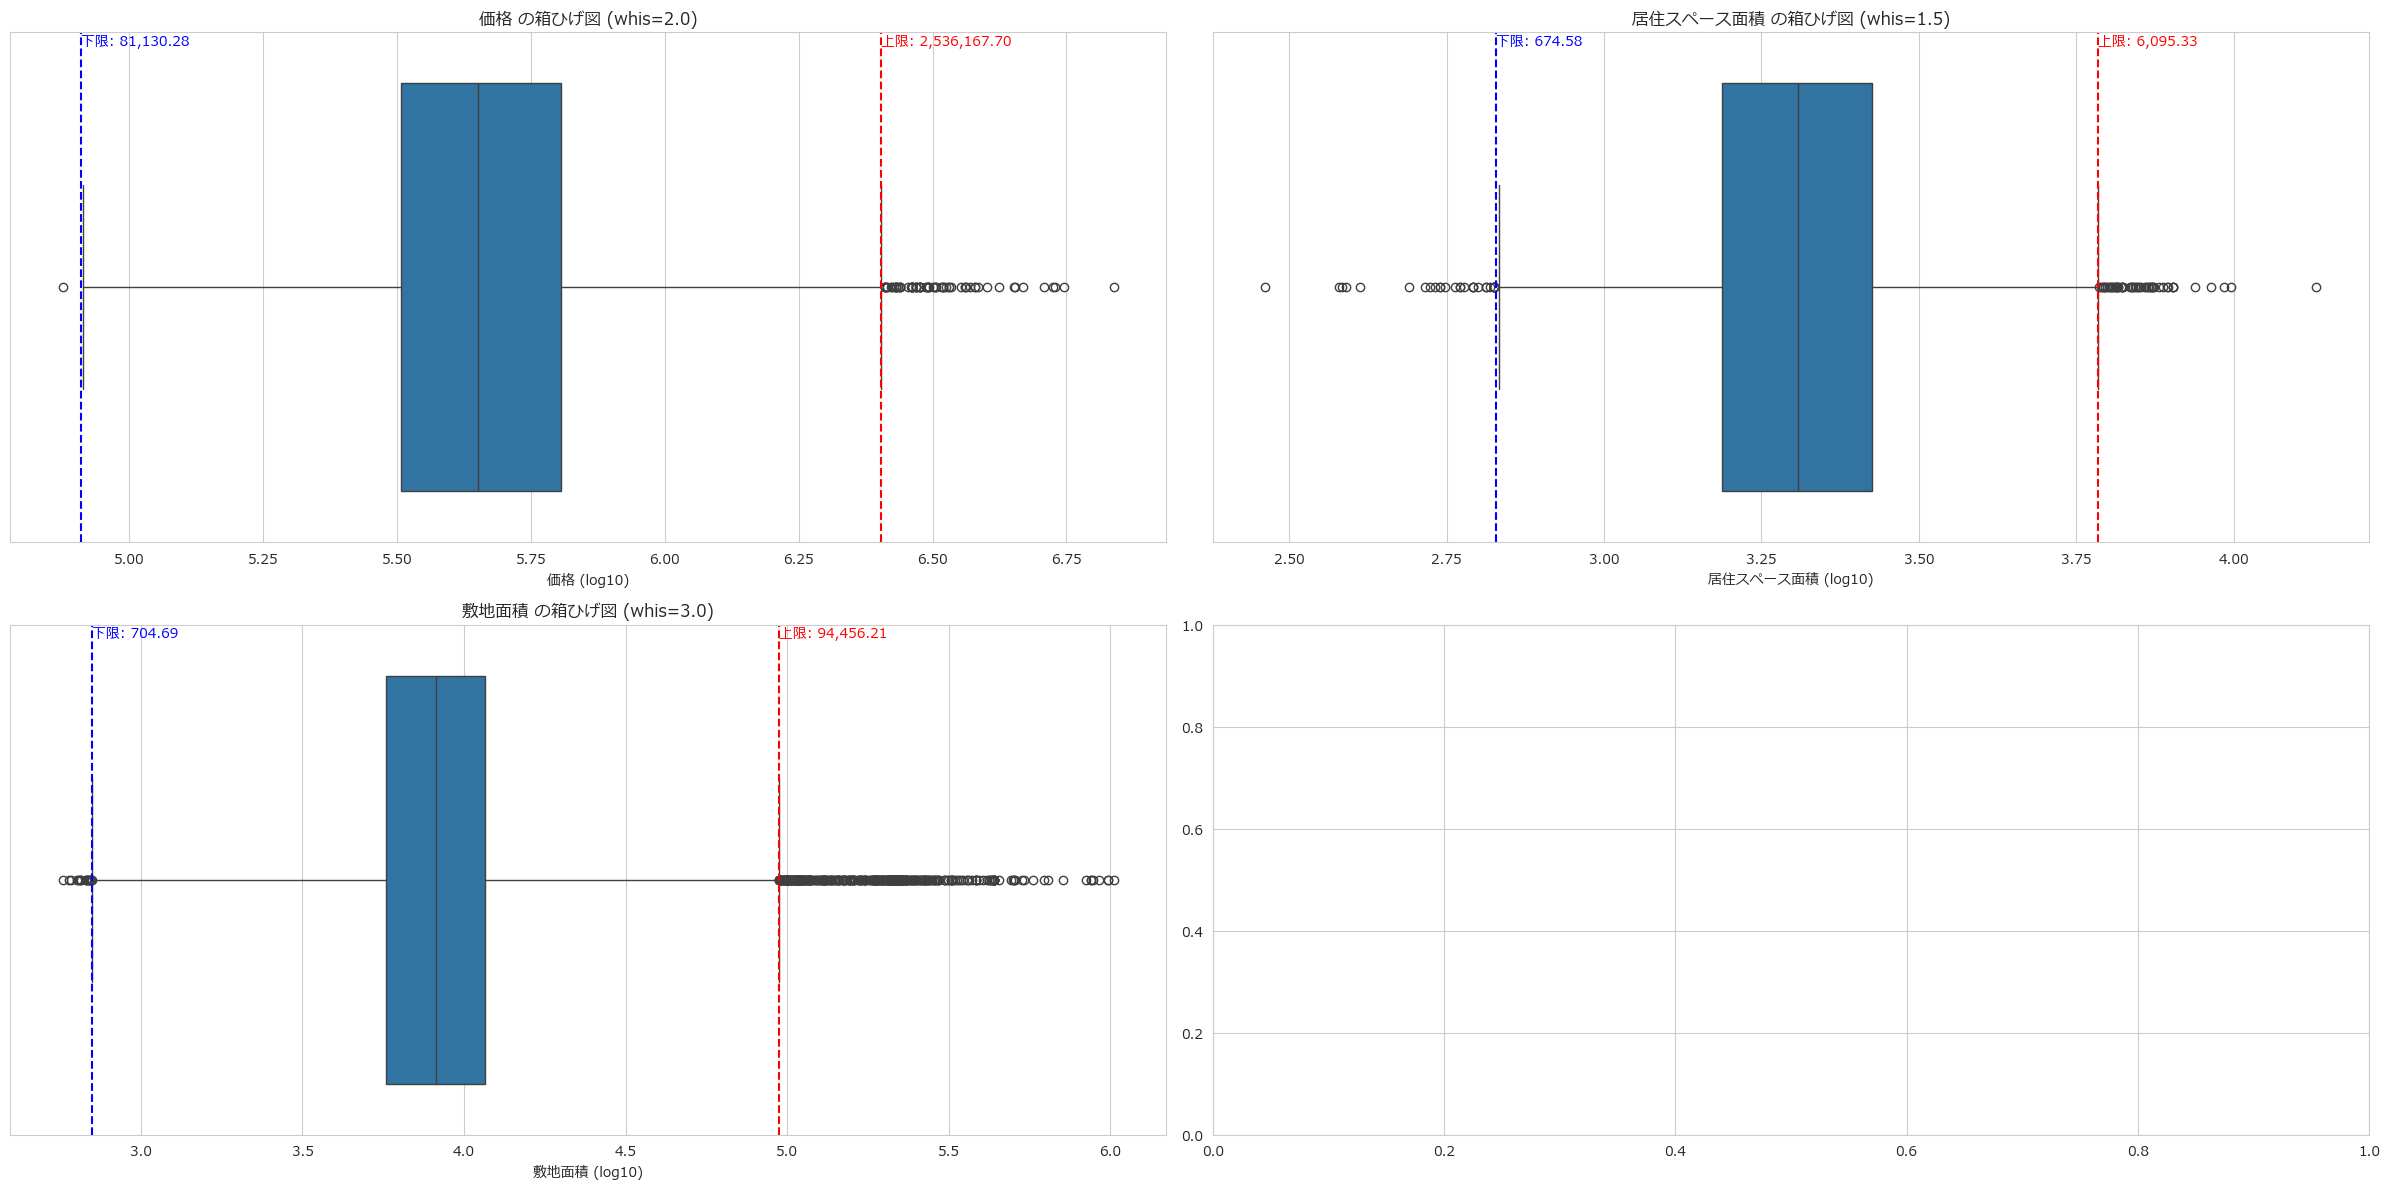

計算された上限値と下限値:
price: 上限 = 2,536,167.70, 下限 = 81,130.28
sqft_living: 上限 = 6,095.33, 下限 = 674.58
sqft_lot: 上限 = 94,456.21, 下限 = 704.69


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語ラベル用の辞書を追加
feature_names_jp = {
    'date': '日付',
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'yr_renovated': 'リノベーション年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数',
    'age': '築年数',
}

# 日本語フォントの設定
plt.rcParams['font.family'] = 'meiryo'

# 上限値と下限値を保存する辞書を初期化
limits = {}

# Calculate 'age' as the difference between 'year_sold' and 'yr_built'
data['age'] = data['year_sold'] - data['yr_built']

def plot_boxplot_custom_whis(df, column, custom_whis=1.5, log_transform=False):
    """
    指定した列の箱ひげ図をカスタムwhisでプロットし、上限値と下限値を計算して保存する関数。
    
    Parameters:
    - df: pandas DataFrame
    - column: str, 処理対象の列名
    - custom_whis: float, IQRに乗じる係数
    - log_transform: bool, 対数変換を行うかどうか
    """
    if log_transform:
        # 対数変換
        data_transformed = np.log10(df[column])
        xlabel = f"{column} (log10)"
    else:
        data_transformed = df[column]
        xlabel = column
    
    # 箱ひげ図の作成
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data_transformed, whis=custom_whis)
    plt.title(f"{column} の箱ひげ図 (whis={custom_whis})")
    plt.xlabel(xlabel)
    plt.show()
    
    # 四分位数とIQRの計算
    Q1 = data_transformed.quantile(0.25)
    Q3 = data_transformed.quantile(0.75)
    IQR = Q3 - Q1
    upper_whisker = Q3 + custom_whis * IQR
    lower_whisker = Q1 - custom_whis * IQR
    
    if log_transform:
        # 元のスケールに戻す
        upper_limit = 10 ** upper_whisker
        lower_limit = 10 ** lower_whisker
    else:
        upper_limit = upper_whisker
        lower_limit = lower_whisker
    
    # 上限値と下限値を辞書に保存
    limits[column] = {'upper_limit': upper_limit, 'lower_limit': lower_limit}
    
    print(f"--- {column} の上限値と下限値 ---")
    if log_transform:
        print(f"箱ひげ図の上限（対数スケール）: {upper_whisker:.2f}")
        print(f"箱ひげ図の下限（対数スケール）: {lower_whisker:.2f}")
        print(f"箱ひげ図の上限（元のスケール）: {upper_limit:,.2f} ")
        print(f"箱ひげ図の下限（元のスケール）: {lower_limit:,.2f} ")
    else:
        print(f"{column} の上限: {upper_limit:,.2f}")
        print(f"{column} の下限: {lower_limit:,.2f}")
    print("\n")

# 処理対象の列と設定（各列ごとに異なるwhisを設定）
columns_to_plot = [
    {'column': 'price', 'custom_whis': 2.0, 'log_transform': True},
    {'column': 'sqft_living', 'custom_whis': 1.5, 'log_transform': True},
    {'column': 'sqft_lot', 'custom_whis': 3.0, 'log_transform': True},
]

# 複数の箱ひげ図を一つの画像にまとめて表示（日本語ラベル対応）
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
axes = axes.flatten()

for ax, col_info in zip(axes, columns_to_plot):
    jp_label = feature_names_jp.get(col_info['column'], col_info['column'])
    
    if col_info['log_transform']:
        data_plot = np.log10(data[col_info['column']])
        xlabel = f"{jp_label} (log10)"
    else:
        data_plot = data[col_info['column']]
        xlabel = jp_label
    
    sns.boxplot(x=data_plot, whis=col_info['custom_whis'], ax=ax)
    ax.set_title(f"{jp_label} の箱ひげ図 (whis={col_info['custom_whis']})")
    ax.set_xlabel(xlabel)
    
    # 四分位数とIQRの計算
    Q1 = data_plot.quantile(0.25)
    Q3 = data_plot.quantile(0.75)
    IQR = Q3 - Q1
    upper_whisker = Q3 + col_info['custom_whis'] * IQR
    lower_whisker = Q1 - col_info['custom_whis'] * IQR
    
    if col_info['log_transform']:
        upper_limit = 10 ** upper_whisker
        lower_limit = 10 ** lower_whisker
    else:
        upper_limit = upper_whisker
        lower_limit = lower_whisker
    
    limits[col_info['column']] = {'upper_limit': upper_limit, 'lower_limit': lower_limit}
    
    # 上限線と下限線の描画
    ax.axvline(upper_whisker, color='red', linestyle='--')
    ax.axvline(lower_whisker, color='blue', linestyle='--')
    ax.text(upper_whisker, ax.get_ylim()[1] * 0.95, f'上限: {upper_limit:,.2f}', color='red')
    ax.text(lower_whisker, ax.get_ylim()[1] * 0.95, f'下限: {lower_limit:,.2f}', color='blue')

plt.tight_layout()
plt.show()

# 上限値と下限値の確認
print("計算された上限値と下限値:")
for column, lim in limits.items():
    print(f"{column}: 上限 = {lim['upper_limit']:,.2f}, 下限 = {lim['lower_limit']:,.2f}")


## 5.4 カスタム `whis` によるデータのフィルタリング

前セクションで計算された各列の上下限値を用いて、データフレームから異常値を除外します。このセクションでは、各列ごとに異なる `whis` パラメータに基づいた上下限値を使用してデータをフィルタリングします。

### スクリプト2: データのフィルタリング


In [7]:
# フィルタリング用の関数を定義
def filter_data_custom_whis(df, limits):
    """
    指定した上限値と下限値に基づいてデータフレームをフィルタリングする関数。
    
    Parameters:
    - df: pandas DataFrame
    - limits: dict, 各列の上限値と下限値
    
    Returns:
    - フィルタリング後のDataFrame
    """
    initial_count = df.shape[0]
    for column, lim in limits.items():
        lower_limit = lim['lower_limit']
        upper_limit = lim['upper_limit']
        df = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
        print(f"{column} の範囲 {lower_limit:,.2f} - {upper_limit:,.2f} を用いてフィルタリング完了")
    
    filtered_count = df.shape[0]
    removed_count = initial_count - filtered_count
    
    print(f"\nフィルタリング前のデータ件数: {initial_count}")
    print(f"フィルタリング後のデータ件数: {filtered_count}")
    print(f"除外したデータの件数: {removed_count}")
    
    return df

# 上限値と下限値に基づいてデータをフィルタリング
data_filtered = filter_data_custom_whis(df=data, limits=limits)

# フィルタリング後のデータ確認
display(data_filtered.head())
display(data_filtered.info())


price の範囲 81,130.28 - 2,536,167.70 を用いてフィルタリング完了
sqft_living の範囲 674.58 - 6,095.33 を用いてフィルタリング完了
sqft_lot の範囲 704.69 - 94,456.21 を用いてフィルタリング完了

フィルタリング前のデータ件数: 16674
フィルタリング後のデータ件数: 16096
除外したデータの件数: 578


date   price  sqft_lot  sqft_living  grade   lat    long  yr_built  \
0 2014-10-13  221900      5650         1180      7 47.51 -122.26      1955   
1 2014-12-09  538000      7242         2570      7 47.72 -122.32      1951   
3 2014-12-09  604000      5000         1960      7 47.52 -122.39      1965   
4 2015-02-18  510000      8080         1680      8 47.62 -122.05      1987   
6 2014-06-27  257500      6819         1715      7 47.31 -122.33      1995   

   yr_renovated  year_sold  month_sold  days_since_2014_01_01  renovated_flag  \
0             0       2014          10                    286               0   
1          1991       2014          12                    343               1   
3             0       2014          12                    343               0   
4             0       2015           2                    414               0   
6             0       2014           6                    178               0   

   years_since_renovation  age  
0                       0   59  
1                      23   63  
3                       0   49  
4                       0   28  
6                       0   19

<class 'pandas.core.frame.DataFrame'>
Index: 16096 entries, 0 to 21612
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    16096 non-null  datetime64[ns]
 1   price                   16096 non-null  int64         
 2   sqft_lot                16096 non-null  int64         
 3   sqft_living             16096 non-null  int64         
 4   grade                   16096 non-null  int64         
 5   lat                     16096 non-null  float64       
 6   long                    16096 non-null  float64       
 7   yr_built                16096 non-null  int64         
 8   yr_renovated            16096 non-null  int64         
 9   year_sold               16096 non-null  int32         
 10  month_sold              16096 non-null  int32         
 11  days_since_2014_01_01   16096 non-null  int64         
 12  renovated_flag          16096 non-null  int32      

None

## 6. 追加の特徴量エンジニアリング

データの品質向上とモデルの性能向上を図るために、追加の特徴量エンジニアリングを実施します。具体的には以下の2つのステップを行います。

1. **物件の築年数 (`age`) の算出**
2. **地域別の特徴量の作成**

これらの特徴量を追加することで、物件の物理的な特性や地理的な位置情報をモデルに反映させ、予測精度の向上を目指します。


### 6.1 物件の築年数 (`age`) の算出

`yr_built`（建築年）と `year_sold`（売却年）から物件の築年数を計算し、新たな特徴量 `age` を作成します。築年数は物件の状態や市場価値に影響を与える重要な要素となるため、モデルにおいて有用な特徴量となります。


In [8]:
# 6.1 物件の築年数 (`age`) の算出

# 物件の築年数を計算
data_filtered['age'] = data_filtered['year_sold'] - data_filtered['yr_built']

# 確認
display(data_filtered[['yr_built', 'year_sold', 'age']].head())


yr_built  year_sold  age
0      1955       2014   59
1      1951       2014   63
3      1965       2014   49
4      1987       2015   28
6      1995       2014   19

### 6.2 地域別の特徴量の作成

`lat`（緯度）と `long`（経度）を用いて、物件の地域をクラスタリングし、地域別のカテゴリ変数を作成します。ここでは、K-Meansクラスタリングを用いて物件を複数の地域グループに分類します。これにより、地理的な特徴をモデルに組み込むことが可能となります。


c:\Users\rainb\Projects\DeNA_dataScience\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


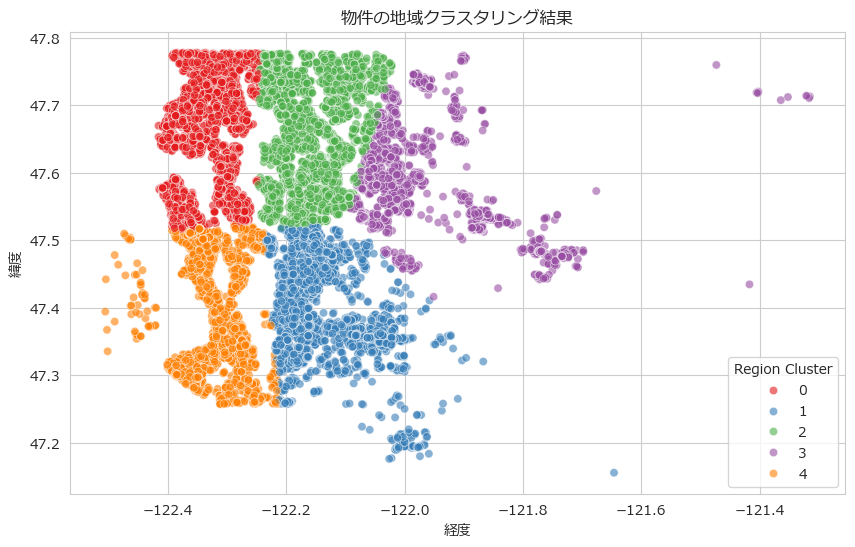

In [9]:
# 6.2 地域別の特徴量の作成

from sklearn.cluster import KMeans

# クラスタリングに使用する緯度と経度の抽出
coordinates = data_filtered[['lat', 'long']]

# クラスタ数の設定（例: 5クラス）
n_clusters = 5

# K-Meansクラスタリングの実行
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_filtered['region_cluster'] = kmeans.fit_predict(coordinates)

# クラスタリング結果の確認
plt.figure(figsize=(10, 6))
sns.scatterplot(x='long', y='lat', hue='region_cluster', palette='Set1', data=data_filtered, legend='full', alpha=0.6)
plt.title("物件の地域クラスタリング結果")
plt.xlabel("経度")
plt.ylabel("緯度")
plt.legend(title='Region Cluster')
plt.show()


### 6.3 特徴量のエンコーディング

クラスタリングによって作成した `region_cluster` は数値データとしてモデルに取り込むことができますが、カテゴリ変数として扱う場合はワンホットエンコーディングを適用します。以下では、`region_cluster` をダミー変数に変換します。


In [10]:
# 6.3 特徴量のエンコーディング

# ワンホットエンコーディングの適用
region_dummies = pd.get_dummies(data_filtered['region_cluster'], prefix='region')
data_final = pd.concat([data_filtered.drop('region_cluster', axis=1), region_dummies], axis=1)

# 'region_cluster' 列を data_final に保持
data_final['region_cluster'] = data_filtered['region_cluster']


平均距離: 8.55
標準偏差: 4.33
距離の閾値 (平均 + 2*標準偏差): 17.20

地理的外れ値除外前のデータ件数: 16096
地理的外れ値除外後のデータ件数: 15729
除外した地理的外れ値の件数: 367


date   price  sqft_lot  sqft_living  grade   lat    long  yr_built  \
0 2014-10-13  221900      5650         1180      7 47.51 -122.26      1955   
1 2014-12-09  538000      7242         2570      7 47.72 -122.32      1951   
3 2014-12-09  604000      5000         1960      7 47.52 -122.39      1965   
4 2015-02-18  510000      8080         1680      8 47.62 -122.05      1987   
6 2014-06-27  257500      6819         1715      7 47.31 -122.33      1995   

   yr_renovated  year_sold  ...  days_since_2014_01_01  renovated_flag  \
0             0       2014  ...                    286               0   
1          1991       2014  ...                    343               1   
3             0       2014  ...                    343               0   
4             0       2015  ...                    414               0   
6             0       2014  ...                    178               0   

   years_since_renovation  age  region_0  region_1  region_2  region_3  \
0                       0   59     False     False     False     False   
1                      23   63      True     False     False     False   
3                       0   49      True     False     False     False   
4                       0   28     False     False     False      True   
6                       0   19     False     False     False     False   

   region_4  region_cluster  
0      True               4  
1     False               0  
3     False               0  
4     False               3  
6      True               4  

[5 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 15729 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    15729 non-null  datetime64[ns]
 1   price                   15729 non-null  int64         
 2   sqft_lot                15729 non-null  int64         
 3   sqft_living             15729 non-null  int64         
 4   grade                   15729 non-null  int64         
 5   lat                     15729 non-null  float64       
 6   long                    15729 non-null  float64       
 7   yr_built                15729 non-null  int64         
 8   yr_renovated            15729 non-null  int64         
 9   year_sold               15729 non-null  int32         
 10  month_sold              15729 non-null  int32         
 11  days_since_2014_01_01   15729 non-null  int64         
 12  renovated_flag          15729 non-null  int32      

None

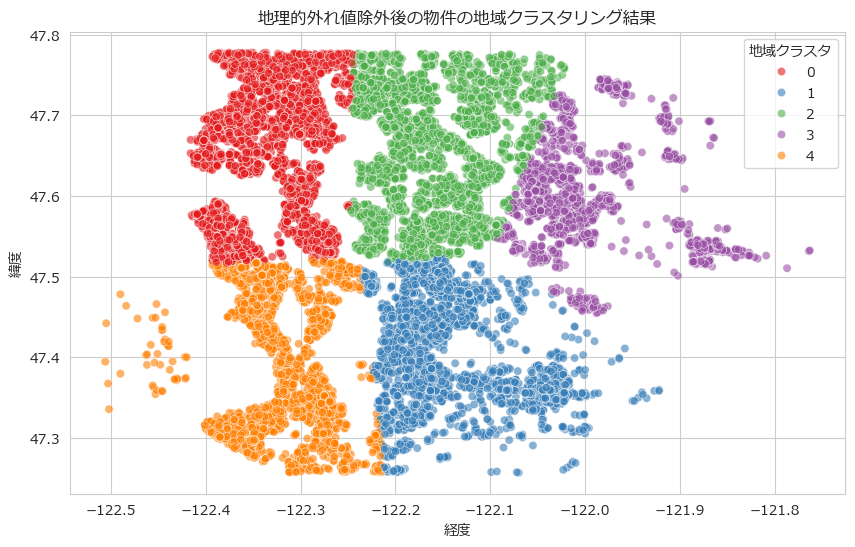

In [11]:
# 5.6 地理的外れ値の除外

import numpy as np
import pandas as pd

# クラスタの中心を取得
cluster_centers = kmeans.cluster_centers_

# 各データポイントが所属するクラスタの中心を取得
# KMeansクラスタリングで使用した 'lat' と 'long' の順序に注意
data_final['cluster_center_lat'] = cluster_centers[data_final['region_cluster'], 0]
data_final['cluster_center_long'] = cluster_centers[data_final['region_cluster'], 1]

# Haversine距離を計算する関数
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    緯度経度を用いて2点間のHaversine距離を計算する関数。
    
    Parameters:
    - lat1, lon1: 配列またはスカラー値。点1の緯度と経度。
    - lat2, lon2: 配列またはスカラー値。点2の緯度と経度。
    
    Returns:
    - distance: 点間の距離。
    """
    # ラジアンに変換
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    R = 6371  # 地球の半径
    distance = R * c
    return distance

# 各データポイントからクラスタ中心までの距離を計算
data_final['distance_to_centroid'] = haversine_distance(
    data_final['lat'],
    data_final['long'],
    data_final['cluster_center_lat'],
    data_final['cluster_center_long']
)

# 距離の統計量を確認
distance_mean = data_final['distance_to_centroid'].mean()
distance_std = data_final['distance_to_centroid'].std()
distance_threshold = distance_mean + 2 * distance_std

print(f"平均距離: {distance_mean:.2f}")
print(f"標準偏差: {distance_std:.2f}")
print(f"距離の閾値 (平均 + 2*標準偏差): {distance_threshold:.2f}")

# 外れ値を除外
initial_count = data_final.shape[0]
data_final = data_final[data_final['distance_to_centroid'] <= distance_threshold]
filtered_count = data_final.shape[0]
removed_count = initial_count - filtered_count

print(f"\n地理的外れ値除外前のデータ件数: {initial_count}")
print(f"地理的外れ値除外後のデータ件数: {filtered_count}")
print(f"除外した地理的外れ値の件数: {removed_count}")

# 不要な列を削除
data_final = data_final.drop(['cluster_center_lat', 'cluster_center_long', 'distance_to_centroid'], axis=1)

# フィルタリング後のデータ確認
display(data_final.head())
display(data_final.info())

# 地理的外れ値除外後のデータをプロット

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='long',
    y='lat',
    hue='region_cluster',
    palette='Set1',
    data=data_final,
    legend='full',
    alpha=0.6
)
plt.title("地理的外れ値除外後の物件の地域クラスタリング結果")
plt.xlabel("経度")
plt.ylabel("緯度")
plt.legend(title='地域クラスタ')
plt.show()

### 6.4 リノベーション無し物件はリノベーション済物件と取り扱いを変える
リノベーション無しの物件のデータはリノベーション経過年数が0になっており、リノベーション経過年数が1年のデータとデータとして近くなってしまうが、実際にはそこに大きな違いがある。そのため、リノベーション無しの物件はリノベーション経過年数を0にせず、NaNにする。

In [12]:
# ### リノベーションフラグが0のデータの処理

# リノベーションフラグが0のデータについて、リノベーション経過年数 (`years_since_renovation`) を0にするのではなく、`NaN`（欠損値）に設定します。

import numpy as np

# リノベーションフラグが0の行の 'years_since_renovation' を NaN に設定
data_final.loc[data_final['renovated_flag'] == 0, 'years_since_renovation'] = np.nan

# フィルタリング後のデータを確認
display(data_final.head())
display(data_final.info())


date   price  sqft_lot  sqft_living  grade   lat    long  yr_built  \
0 2014-10-13  221900      5650         1180      7 47.51 -122.26      1955   
1 2014-12-09  538000      7242         2570      7 47.72 -122.32      1951   
3 2014-12-09  604000      5000         1960      7 47.52 -122.39      1965   
4 2015-02-18  510000      8080         1680      8 47.62 -122.05      1987   
6 2014-06-27  257500      6819         1715      7 47.31 -122.33      1995   

   yr_renovated  year_sold  ...  days_since_2014_01_01  renovated_flag  \
0             0       2014  ...                    286               0   
1          1991       2014  ...                    343               1   
3             0       2014  ...                    343               0   
4             0       2015  ...                    414               0   
6             0       2014  ...                    178               0   

   years_since_renovation  age  region_0  region_1  region_2  region_3  \
0                     NaN   59     False     False     False     False   
1                   23.00   63      True     False     False     False   
3                     NaN   49      True     False     False     False   
4                     NaN   28     False     False     False      True   
6                     NaN   19     False     False     False     False   

   region_4  region_cluster  
0      True               4  
1     False               0  
3     False               0  
4     False               3  
6      True               4  

[5 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 15729 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    15729 non-null  datetime64[ns]
 1   price                   15729 non-null  int64         
 2   sqft_lot                15729 non-null  int64         
 3   sqft_living             15729 non-null  int64         
 4   grade                   15729 non-null  int64         
 5   lat                     15729 non-null  float64       
 6   long                    15729 non-null  float64       
 7   yr_built                15729 non-null  int64         
 8   yr_renovated            15729 non-null  int64         
 9   year_sold               15729 non-null  int32         
 10  month_sold              15729 non-null  int32         
 11  days_since_2014_01_01   15729 non-null  int64         
 12  renovated_flag          15729 non-null  int32      

None

## 7. 詳細な探索的データ分析 (EDA)

追加の特徴量エンジニアリングを完了した後、データの詳細な探索的データ分析 (EDA) を実施します。このステップでは、データの傾向やパターン、特徴量間の関係性を深く理解し、予測モデルの構築に向けたインサイトを得ることを目的とします。

以下のサブセクションに分けて分析を行います。

1. **ターゲット変数 (`価格`) の分布確認**
2. **主要特徴量とターゲット変数の関係分析**
3. **相関行列の作成と可視化**
4. **カテゴリ変数の分析**
5. **地域クラスタリングの詳細分析**
6. **特徴量間の関係性の可視化**

---


### 7.1 ターゲット変数 (`価格`) の分布確認

予測対象となる `価格` の分布を確認し、データの偏りや異常値の存在を把握します。価格の分布が偏っている場合、対数変換などの前処理を検討します。


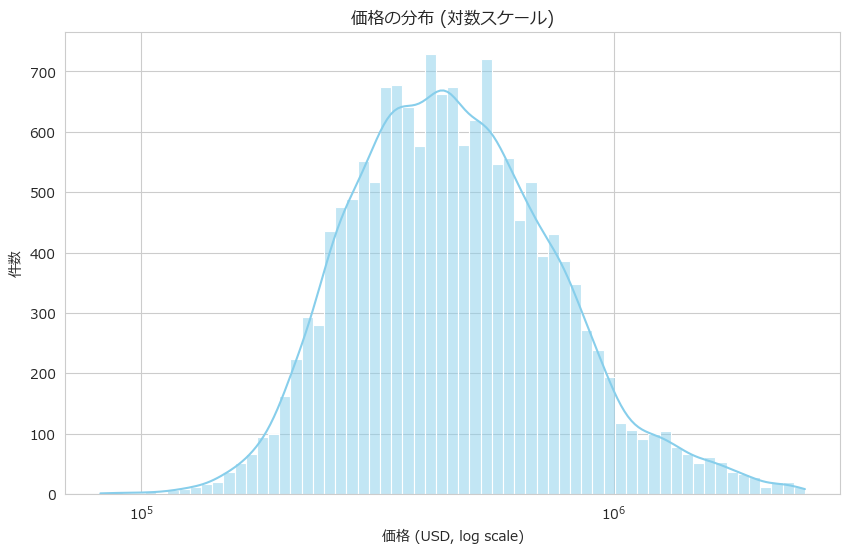

件数         15,729.00
平均        525,135.40
標準偏差      307,233.83
最小         82,000.00
25%       320,000.00
中央値       445,000.00
75%       635,000.00
最大      2,535,000.00
Name: price, dtype: object

In [13]:
# 7.1 ターゲット変数 (`価格`) の分布確認

import matplotlib.pyplot as plt
import seaborn as sns

# 価格のヒストグラム（対数スケール）
plt.figure(figsize=(10, 6))
sns.histplot(data_final['price'], kde=True, color='skyblue', log_scale=True)
plt.title("価格の分布 (対数スケール)")
plt.xlabel("価格 (USD, log scale)")
plt.ylabel("件数")
plt.show()

# 価格の基本統計量
price_stats = data_final['price'].describe()
price_stats = price_stats.rename({
    'count': '件数',
    'mean': '平均',
    'std': '標準偏差',
    'min': '最小',
    '25%': '25%',
    '50%': '中央値',
    '75%': '75%',
    'max': '最大'
})
price_stats = price_stats.apply(lambda x: f"{x:,.2f}")
display(price_stats)


対数グラフにおいてきれいな正規分布に近い形状になっており、このままで問題はなさそう。

### 7.2 主要特徴量とターゲット変数の関係分析

主要な数値特徴量とターゲット変数 `価格` との関係を可視化し、相関の強さやパターンを確認します。これにより、価格に影響を与える可能性のある重要な特徴量を特定します。


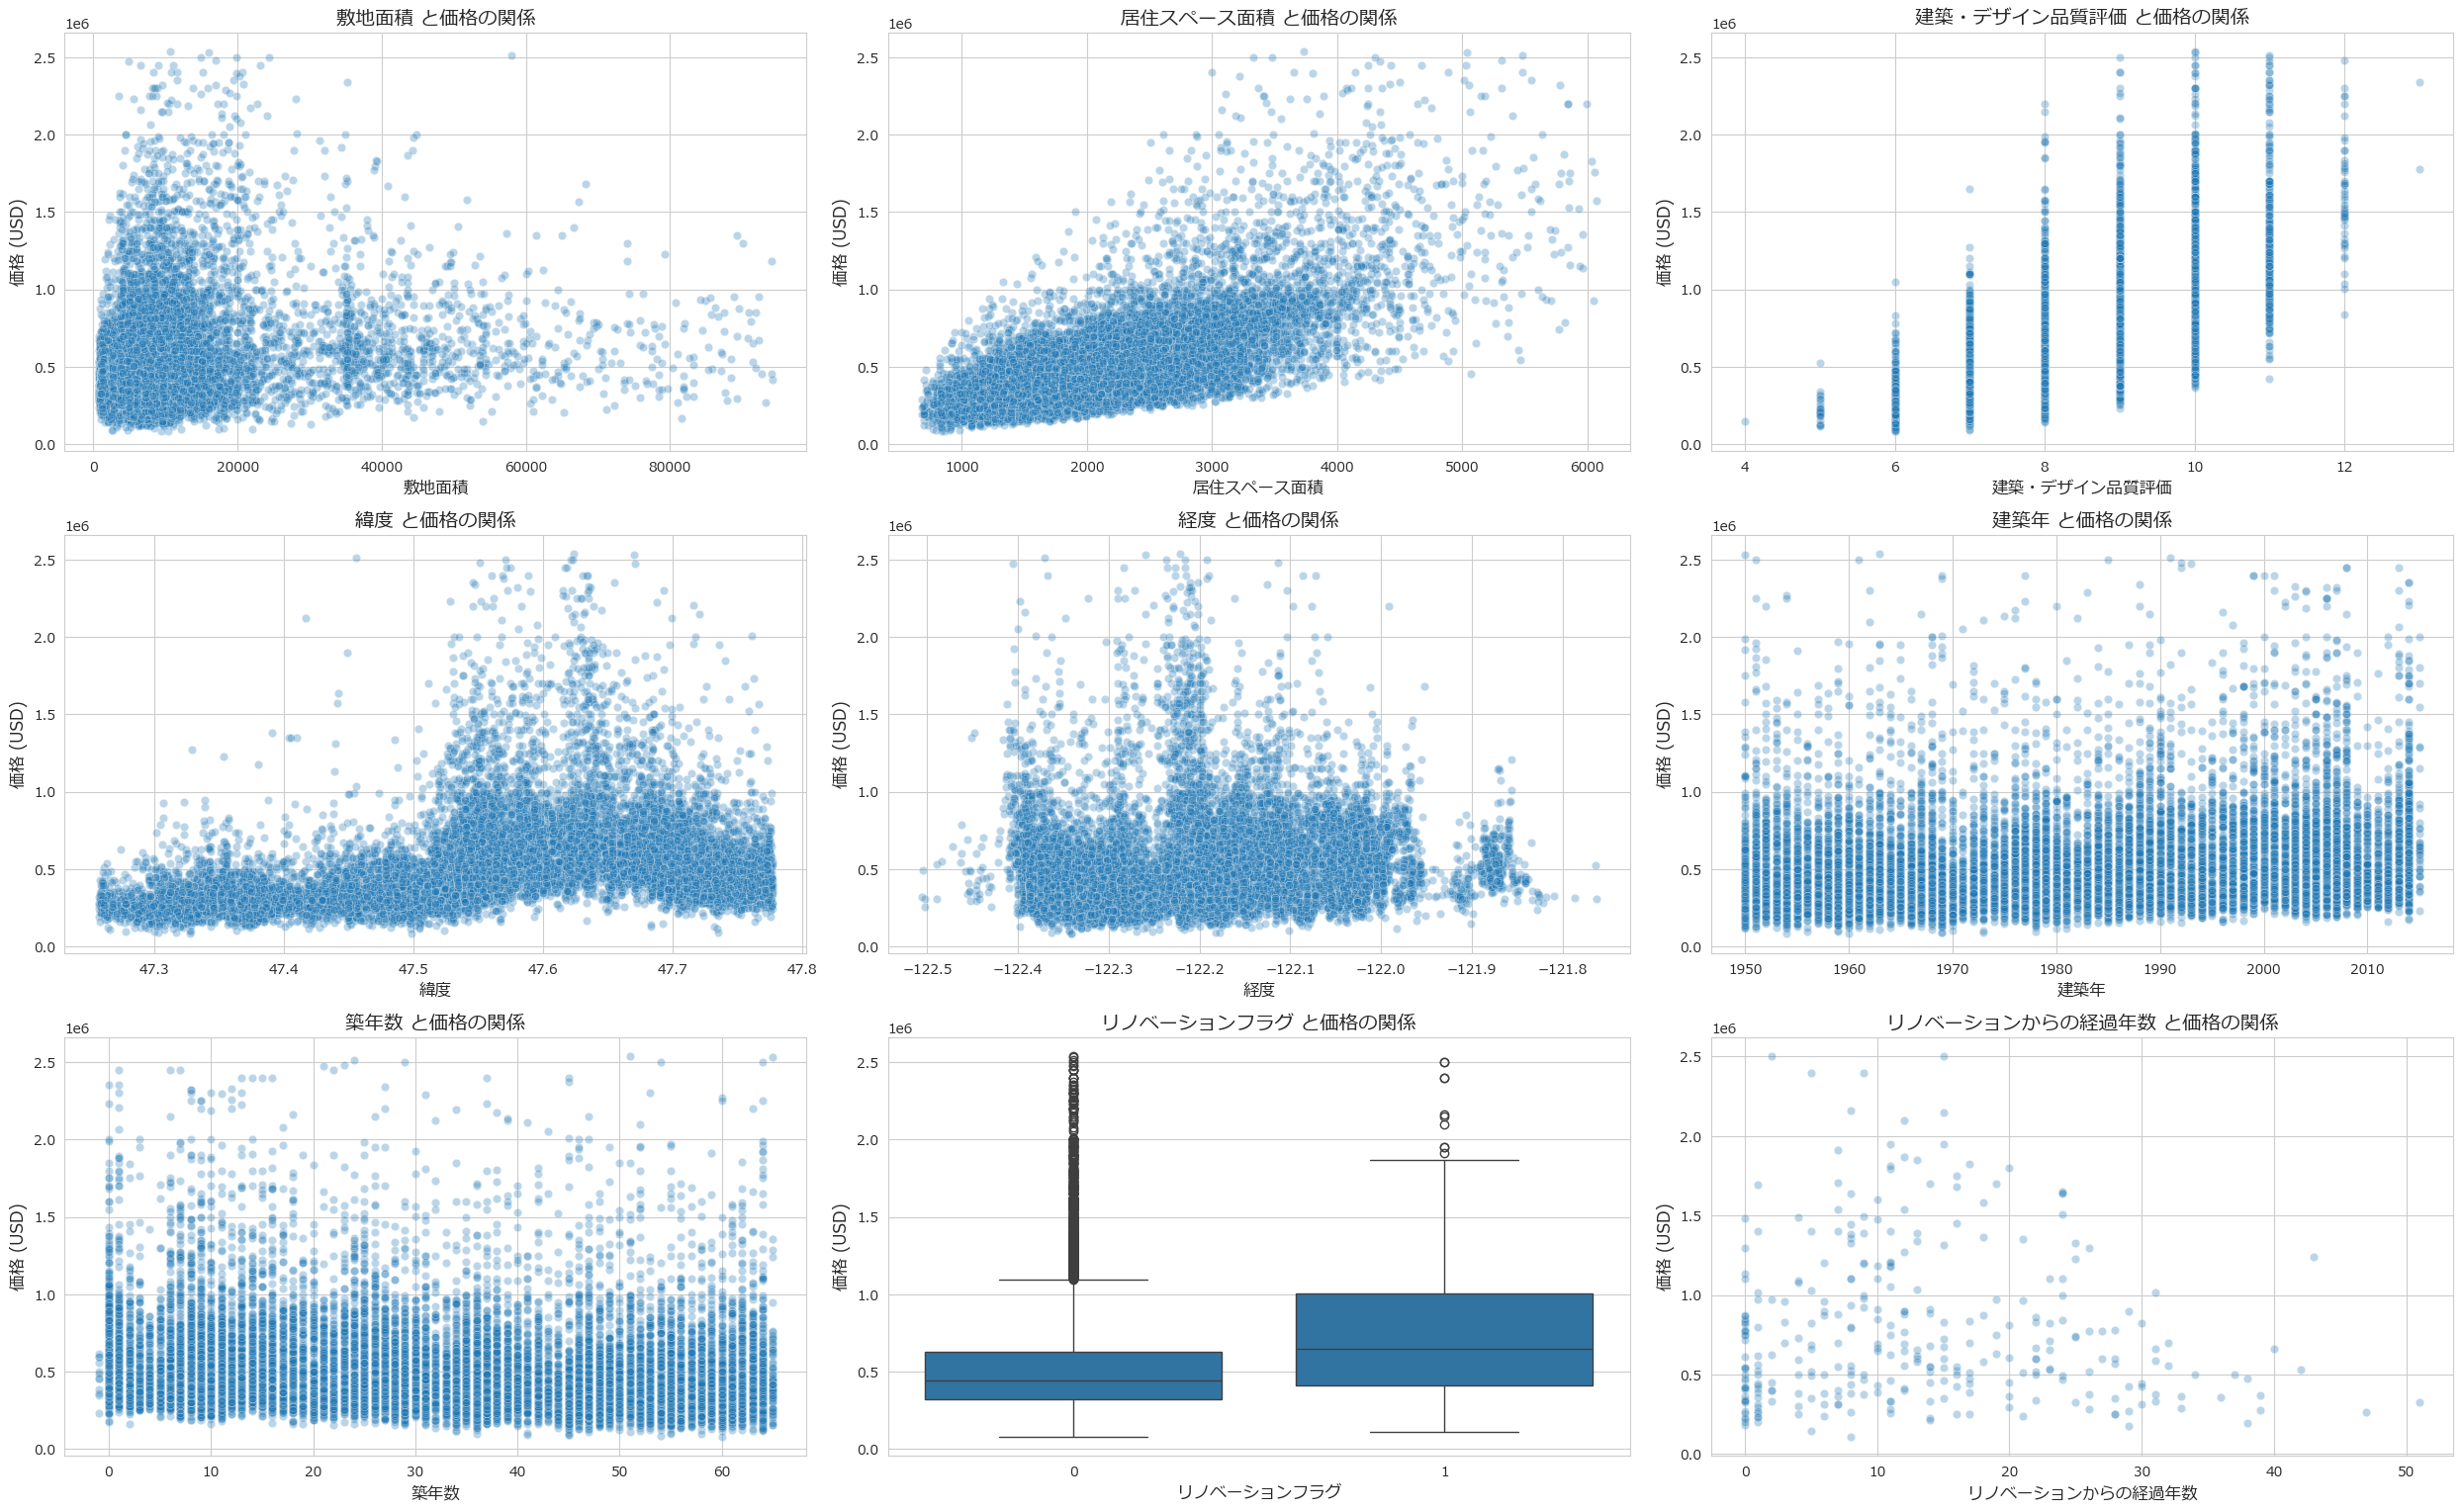

主要特徴量と価格の相関係数 (日本語表示):


価格との相関係数
建築・デザイン品質評価         0.71
居住スペース面積            0.70
緯度                  0.36
敷地面積                0.18
建築年                 0.16
リノベーションフラグ          0.12
経度                  0.10
リノベーションからの経過年数     -0.05
築年数                -0.16

In [14]:
# 7.2 主要特徴量とターゲット変数の関係分析

# 主要数値特徴量のリストにリノベーション関連の特徴量を追加
numeric_features = ['sqft_lot', 'sqft_living', 'grade', 'lat', 'long', 'yr_built', 'age', 'renovated_flag', 'years_since_renovation']

# 日本語ラベルの辞書にリノベーション関連の特徴量を追加
feature_jp = {
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'age': '築年数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
}

# 散布図を作成し、各特徴量を日本語で表示
plt.figure(figsize=(25, 20))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 3, i)
    if feature == 'renovated_flag':
        sns.boxplot(x=data_final[feature], y=data_final['price'])
    else:
        sns.scatterplot(x=data_final[feature], y=data_final['price'], alpha=0.3)
    jp_label = feature_jp.get(feature, feature)
    plt.title(f"{jp_label} と価格の関係", fontsize=14)
    plt.xlabel(jp_label, fontsize=12)
    plt.ylabel("価格 (USD)", fontsize=12)
plt.tight_layout()
plt.show()

# 各特徴量と価格の相関係数
correlations = {}
for feature in numeric_features:
    corr = data_final['price'].corr(data_final[feature])
    correlations[feature] = corr

# 相関係数をテーブル形式で表示 (日本語化)
feature_names = {
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'age': '築年数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
}

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['価格との相関係数'])
corr_df.index = corr_df.index.to_series().apply(lambda x: feature_names.get(x, x))
corr_df = corr_df.sort_values(by='価格との相関係数', ascending=False).round(2)

print("主要特徴量と価格の相関係数 (日本語表示):")
display(corr_df)


他のデータと極端に離れた外れ値データは少なくなっており、フィルタリングが正しく機能したことがわかる。

### 7.3 相関行列の作成と可視化

数値特徴量間の相関関係を把握するために、相関行列を作成しヒートマップで可視化します。これにより、相関の強いペアや多重共線性の可能性を確認します。


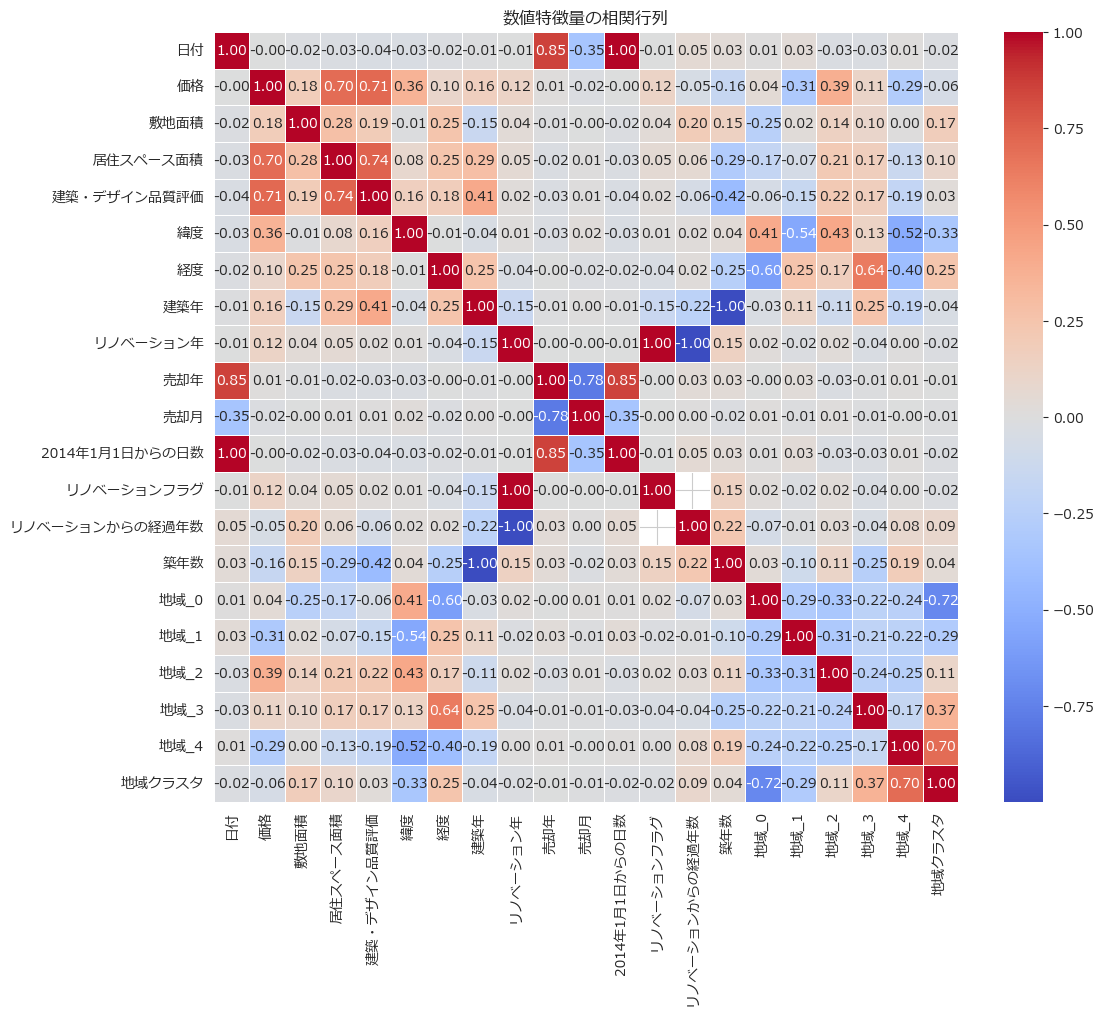

In [15]:
# 列名の日本語対応辞書を更新
feature_names_jp = {
    'date': '日付',
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'yr_renovated': 'リノベーション年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数',
    'age': '築年数',
    'region_0': '地域_0',
    'region_1': '地域_1',
    'region_2': '地域_2',
    'region_3': '地域_3',
    'region_4': '地域_4',
    'region_cluster': '地域クラスタ'
}

# 相関行列の計算
corr_matrix = data_final.corr()

# 日本語フォントの設定
plt.rcParams['font.family'] = 'meiryo'

# 列名を日本語に変更
corr_matrix = corr_matrix.rename(columns=feature_names_jp).rename(index=feature_names_jp)

# ヒートマップの作成
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("数値特徴量の相関行列")
plt.show()
# 相関行列を表形式で表示（スタイル付き）
display(
    corr_matrix.style
    .background_gradient(cmap='coolwarm', vmin=-1, vmax=1)
    .format("{:.2f}")
)

### 7.4 カテゴリ変数の分析

カテゴリ変数である `region_cluster` に基づいて、価格やその他の数値特徴量の分布を比較します。これにより、異なる地域クラスタ間での価格の違いや特徴の違いを確認します。


C:\Users\rainb\AppData\Local\Temp\ipykernel_25528\1561730076.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_melted['cluster'] = filtered_melted['region'].str.replace('region_', '').astype(int)


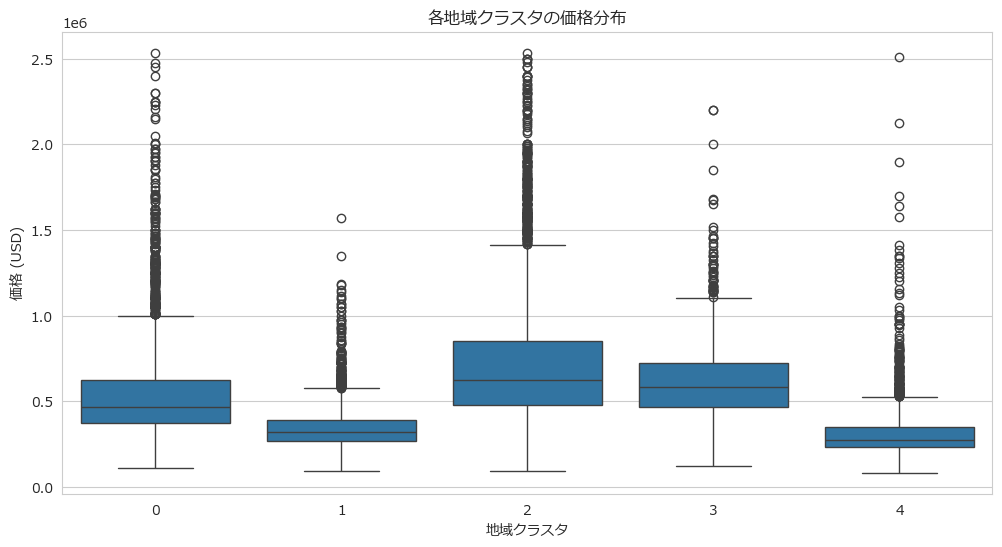

地域クラスタごとの平均価格:


cluster      price
0        0 549,728.24
1        1 345,202.38
2        2 726,091.66
3        3 612,261.32
4        4 315,750.07

In [16]:
# 7.4 カテゴリ変数の分析

# region_cluster のダミー変数名を取得
region_columns = [col for col in data_final.columns if col.startswith('region_') and col != 'region_cluster']

# データを長い形式に変換
melted = pd.melt(data_final, id_vars='price', value_vars=region_columns, var_name='region', value_name='is_region')

# region が True の行のみ抽出
filtered_melted = melted[melted['is_region']]

# クラスタ番号を抽出
filtered_melted['cluster'] = filtered_melted['region'].str.replace('region_', '').astype(int)

# 各地域クラスタごとの価格の分布をボックスプロットで確認
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='price', data=filtered_melted)
plt.title("各地域クラスタの価格分布")
plt.xlabel("地域クラスタ")
plt.ylabel("価格 (USD)")
plt.show()

# 地域クラスタごとの平均価格を計算
region_price_mean = filtered_melted.groupby('cluster')['price'].mean().reset_index()
print("地域クラスタごとの平均価格:")
display(region_price_mean)


### 7.5 地域クラスタリングの詳細分析

地域クラスタリングに基づき、各クラスタの特徴を詳細に分析します。具体的には、各クラスタの平均価格、敷地面積、居住スペース面積などを比較し、地域ごとの特性を把握します。


地域クラスタごとの平均値:


地域クラスタ  平均価格 (USD)  平均敷地面積 (平方フィート)  平均居住スペース面積 (平方フィート)  平均築年数
0       0  549,728.24         5,756.86             1,902.25  32.22
1       1  345,202.38        11,327.87             2,061.28  27.16
2       2  726,091.66        13,448.07             2,466.65  34.68
3       3  612,261.32        13,497.82             2,521.01  18.69
4       4  315,750.07        10,846.02             1,900.41  39.55

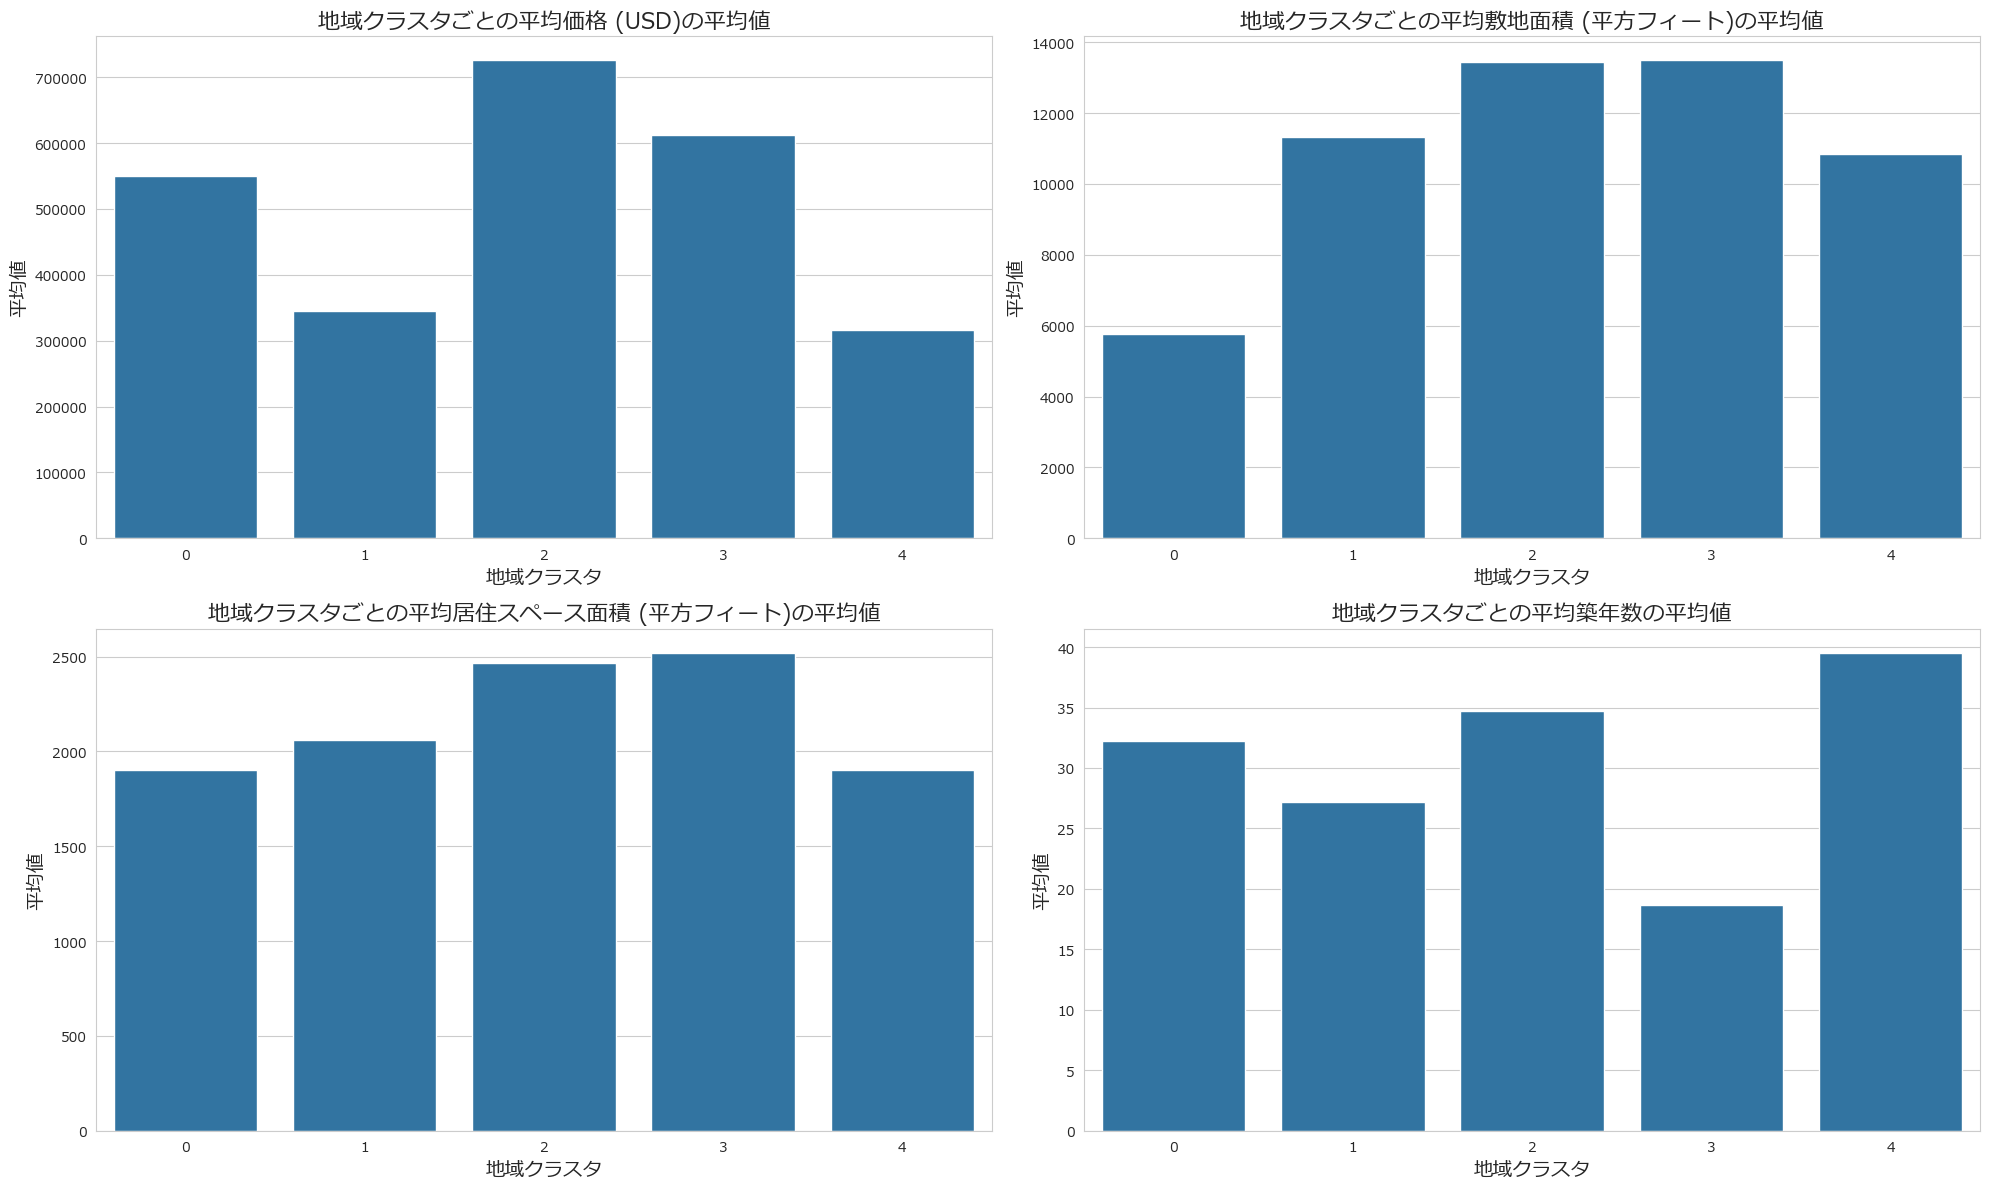

In [17]:
# 7.5 地域クラスタリングの詳細分析

# クラスタごとの主要特徴量の平均を計算
cluster_features_mean = data_final.groupby('region_cluster').mean()[['price', 'sqft_lot', 'sqft_living', 'age']].reset_index()

# クラスタ番号をカテゴリとして扱う場合、必要に応じて型を変換
cluster_features_mean['region_cluster'] = cluster_features_mean['region_cluster'].astype(int)

# カラム名を日本語に変更
cluster_features_mean = cluster_features_mean.rename(columns={
    'region_cluster': '地域クラスタ',
    'price': '平均価格 (USD)',
    'sqft_lot': '平均敷地面積 (平方フィート)',
    'sqft_living': '平均居住スペース面積 (平方フィート)',
    'age': '平均築年数'
})

# 小数点以下を2桁に丸める
cluster_features_mean = cluster_features_mean.round({
    '平均価格 (USD)': 2,
    '平均敷地面積 (平方フィート)': 2,
    '平均居住スペース面積 (平方フィート)': 2,
    '平均築年数': 2
})

# クラスタごとの特徴量の表示
print("地域クラスタごとの平均値:")
display(cluster_features_mean)

# クラスタごとの特徴量を一つの画像にまとめて可視化
features = ['平均価格 (USD)', '平均敷地面積 (平方フィート)', '平均居住スペース面積 (平方フィート)', '平均築年数']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
axes = axes.flatten()

for ax, feature in zip(axes, features):
    sns.barplot(x='地域クラスタ', y=feature, data=cluster_features_mean, ax=ax)
    ax.set_title(f"地域クラスタごとの{feature}の平均値", fontsize=16)
    ax.set_xlabel("地域クラスタ", fontsize=14)
    ax.set_ylabel("平均値", fontsize=14)

plt.tight_layout()
plt.show()


各地域ごとにデータの特性の違いがありそうで、地域ごとに分けた予測モデルを作成する必要がありそう。

### 7.6 リノベーションの有無によるデータ特性の違いを確認

リノベーションフラグの分布:
renovated_flag
0    15418
1      311
Name: count, dtype: int64


C:\Users\rainb\AppData\Local\Temp\ipykernel_25528\1420608718.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='renovated_flag_cat', y='price', data=data_final, palette='Set2')


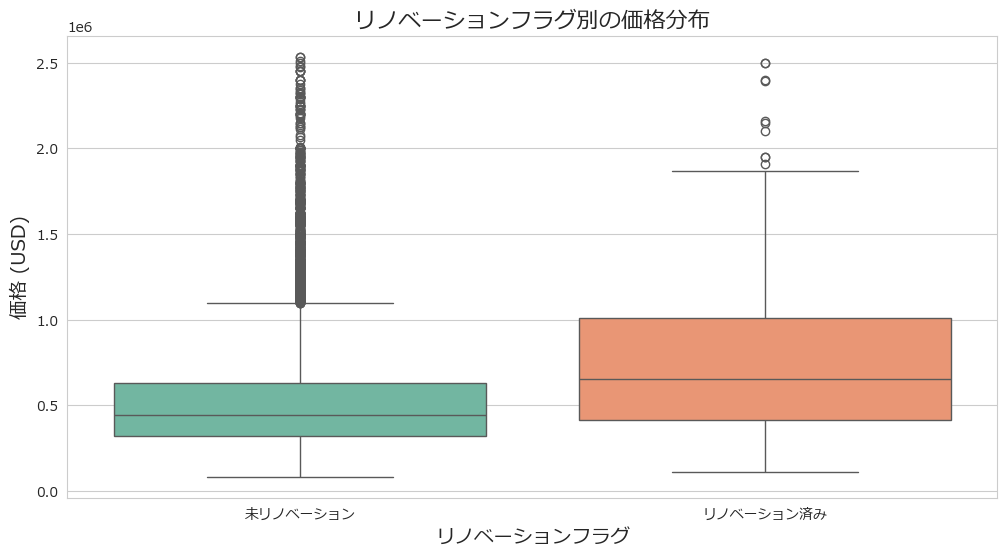

リノベーションフラグ別の価格統計量:


count       mean        std        min        25%  \
renovated_flag_cat                                                         
リノベーション済み             311.00 780,964.00 489,311.26 110,000.00 412,500.00   
未リノベーション           15,418.00 519,975.02 300,225.89  82,000.00 320,000.00   

                          50%          75%          max  
renovated_flag_cat                                       
リノベーション済み          650,000.00 1,007,000.00 2,500,000.00  
未リノベーション           442,500.00   630,000.00 2,535,000.00

C:\Users\rainb\AppData\Local\Temp\ipykernel_25528\1420608718.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='renovated_flag_cat', y=feature, data=data_final, palette='Set3')
C:\Users\rainb\AppData\Local\Temp\ipykernel_25528\1420608718.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='renovated_flag_cat', y=feature, data=data_final, palette='Set3')
C:\Users\rainb\AppData\Local\Temp\ipykernel_25528\1420608718.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='renovated_flag_cat', y=feature, data=data_final, palette='Set3')
C

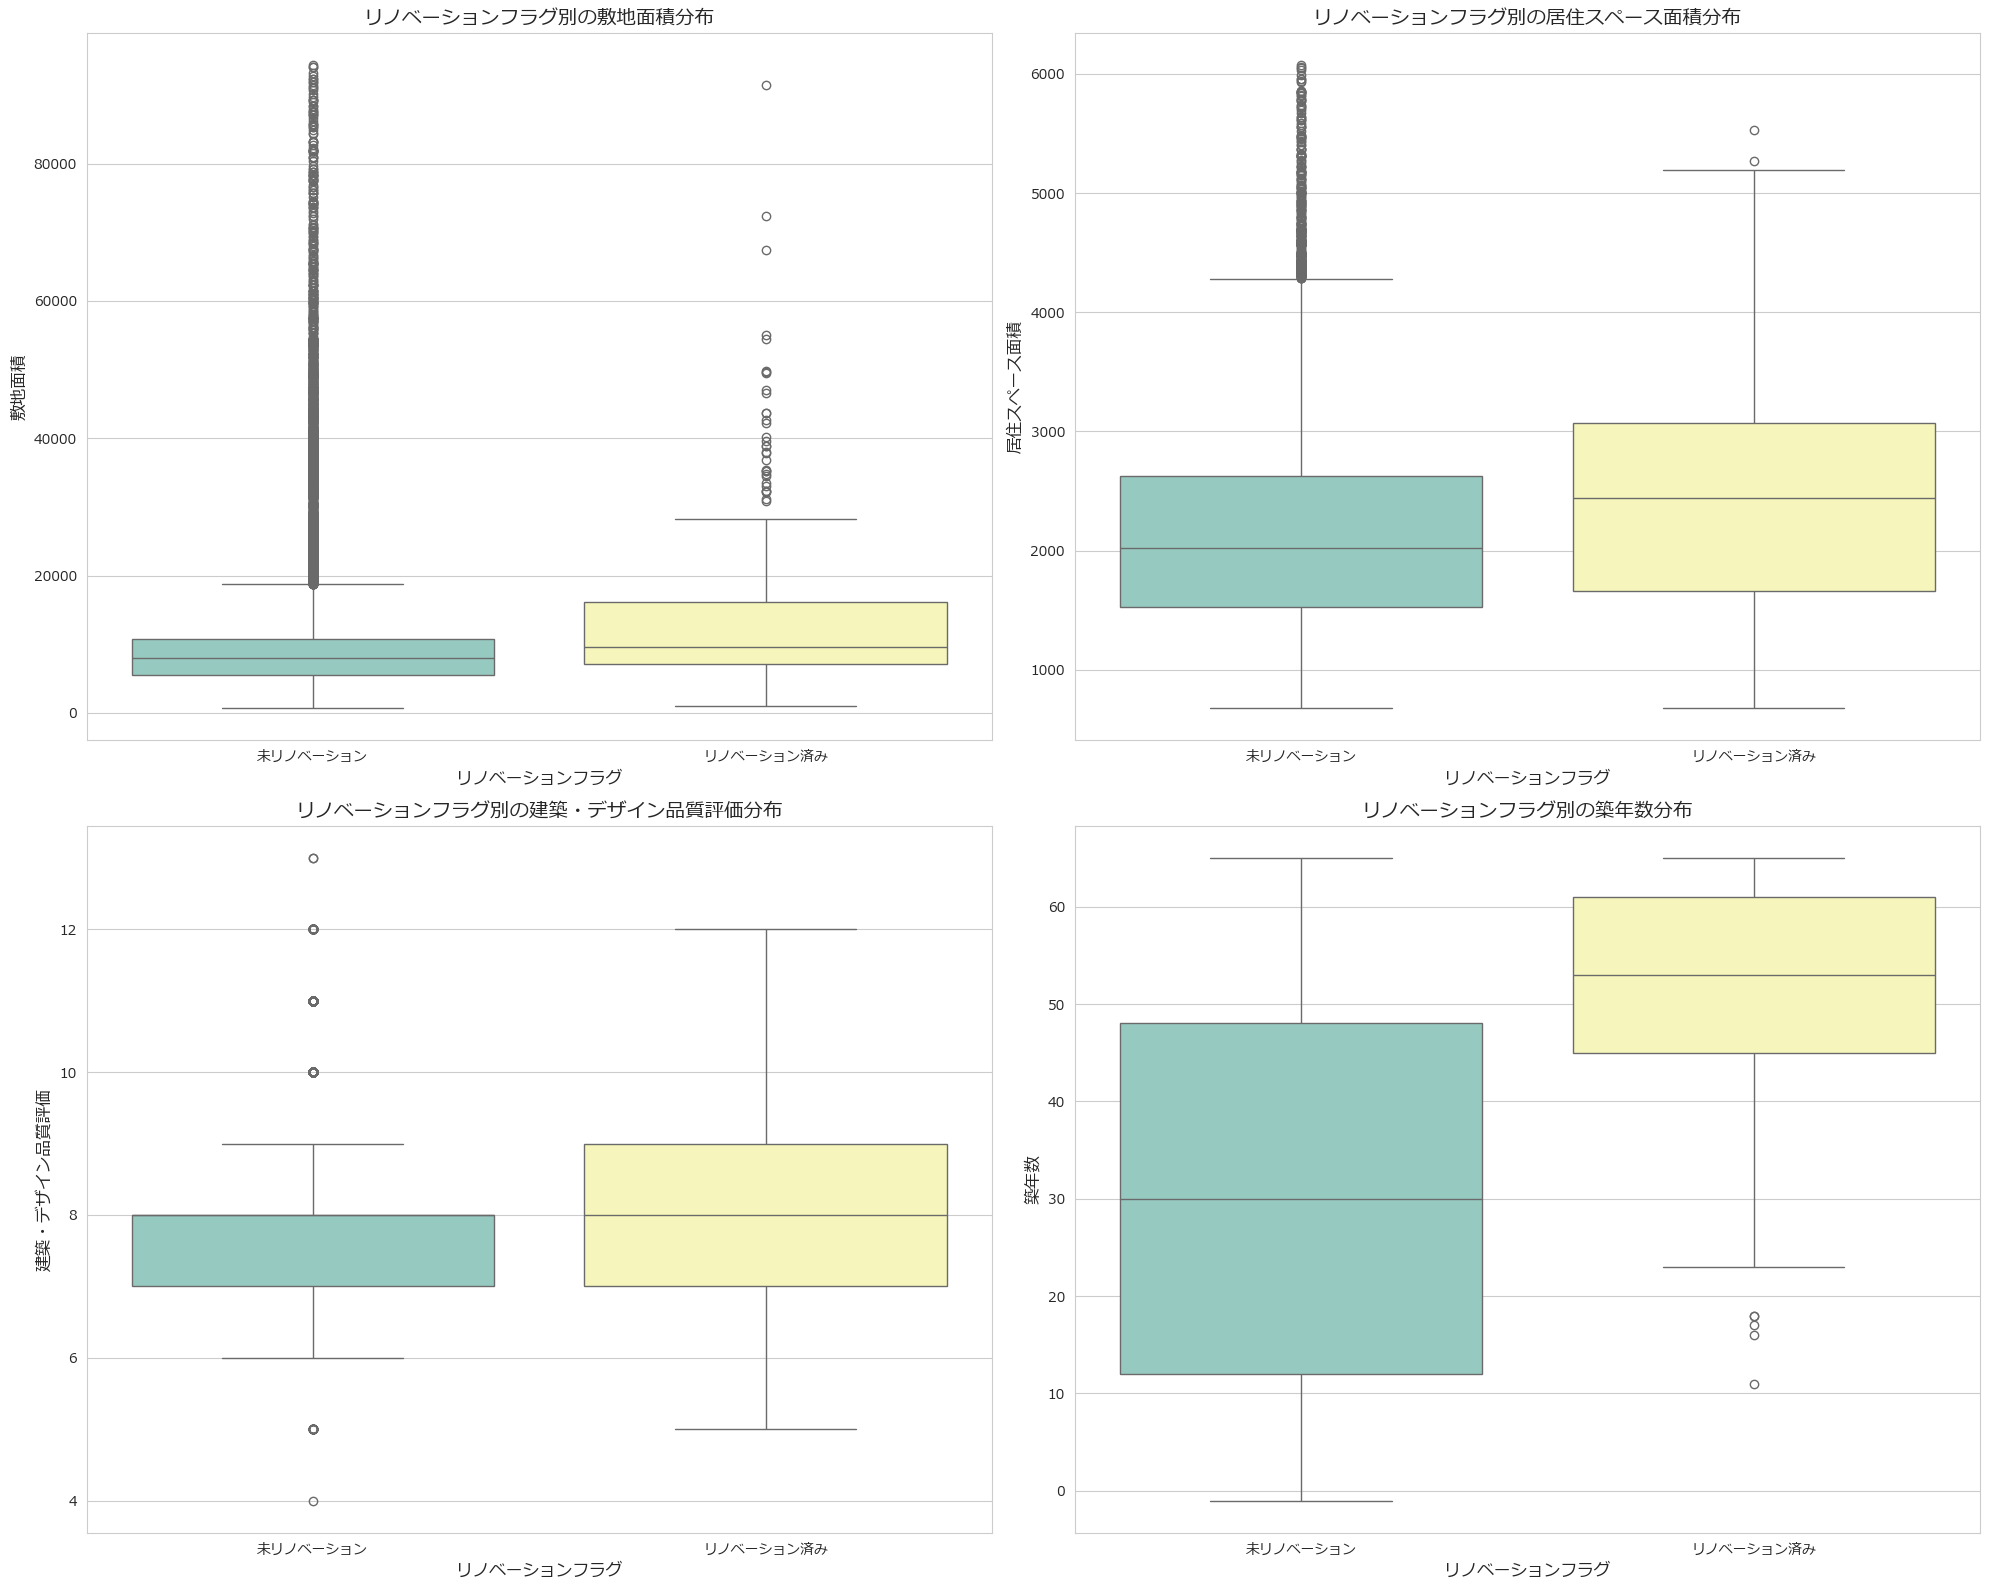

リノベーションフラグ別の主要特徴量の平均値:


sqft_lot  sqft_living  grade   age
renovated_flag_cat                                    
リノベーション済み          13,877.10     2,454.83   8.03 51.23
未リノベーション           10,728.91     2,162.42   7.85 30.64

リノベーションフラグ別の価格との相関係数:


リノベーションフラグ  敷地面積との相関係数  居住スペース面積との相関係数  建築・デザイン品質評価との相関係数  築年数との相関係数
0        NaN        0.06            0.71               0.77      -0.09
1        NaN        0.18            0.70               0.71      -0.19

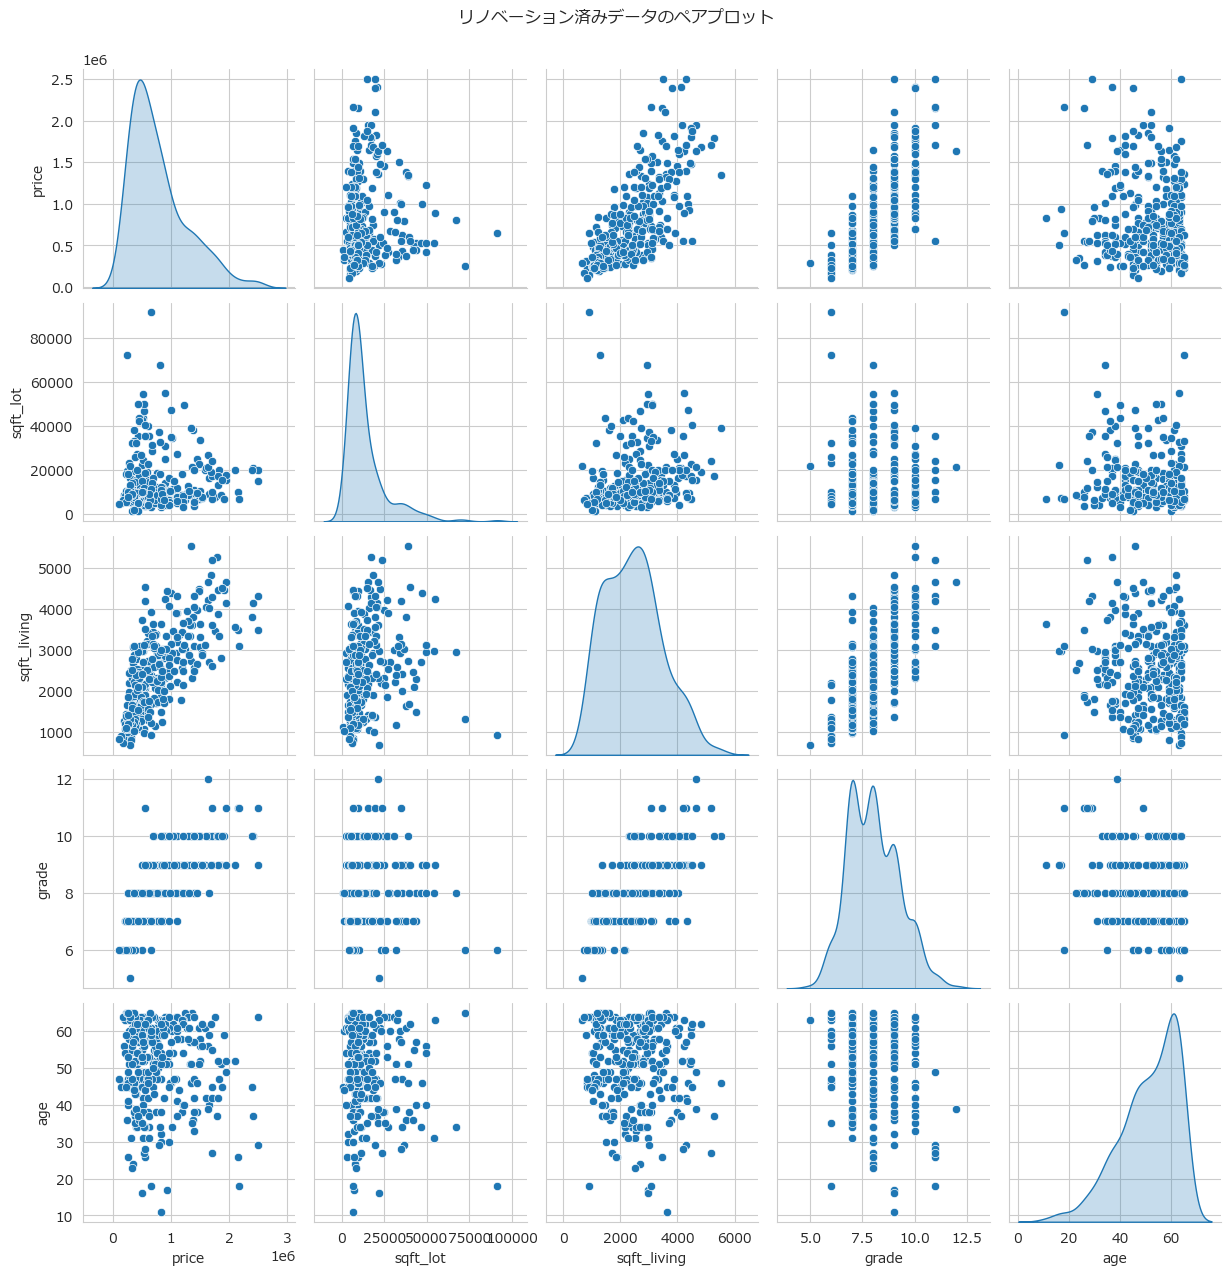

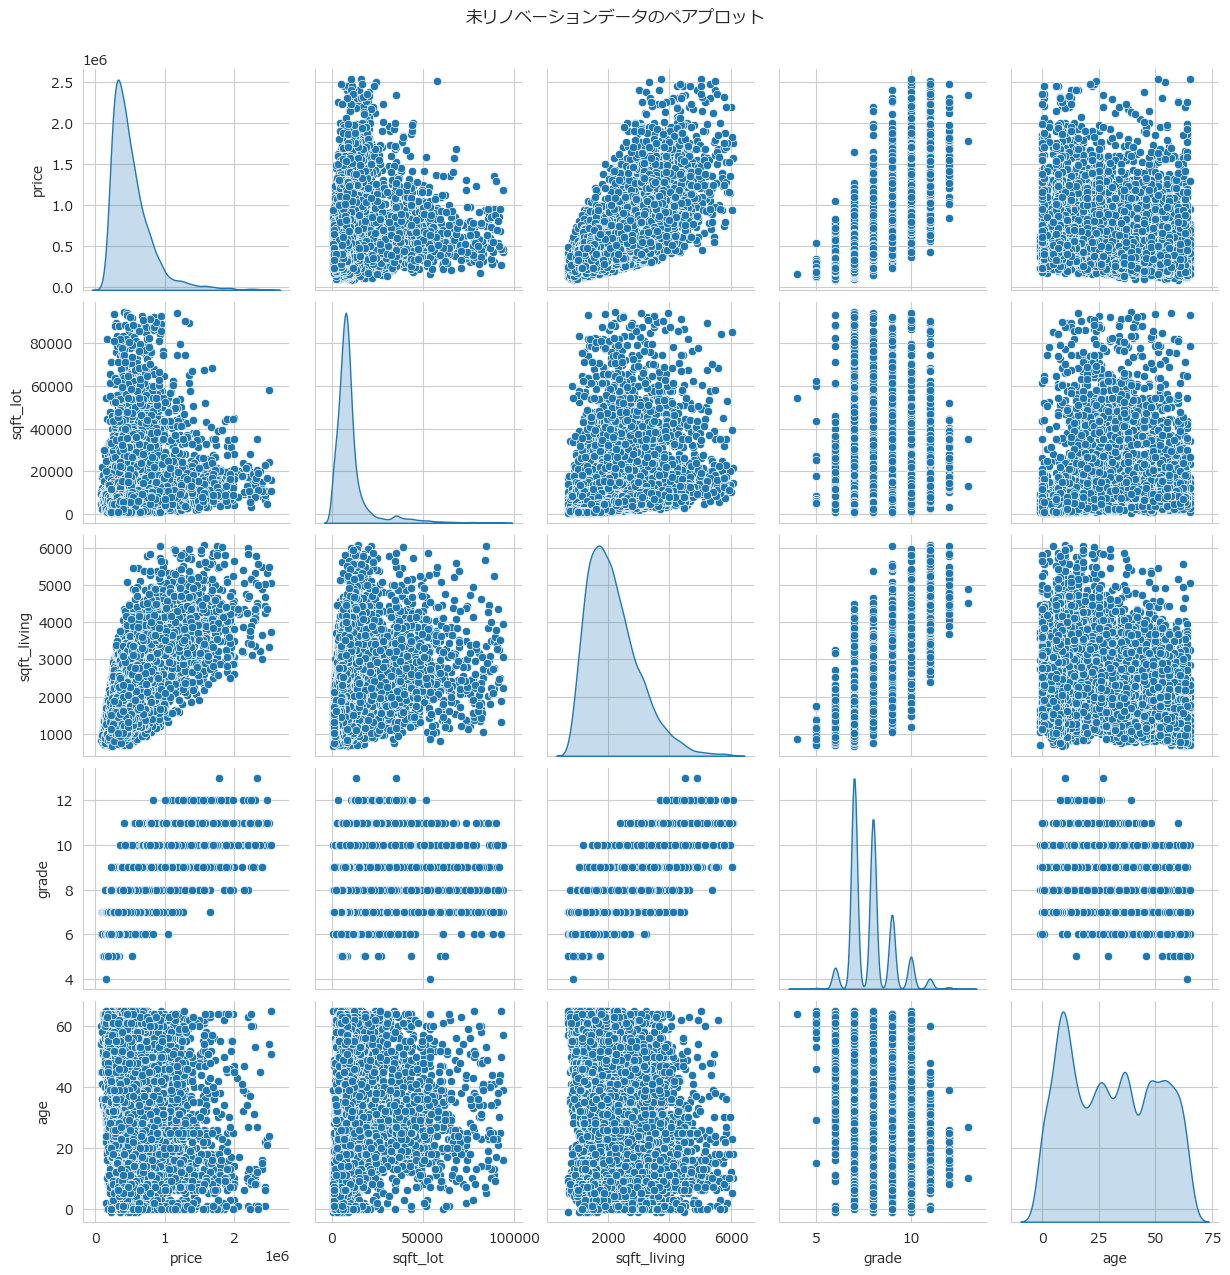

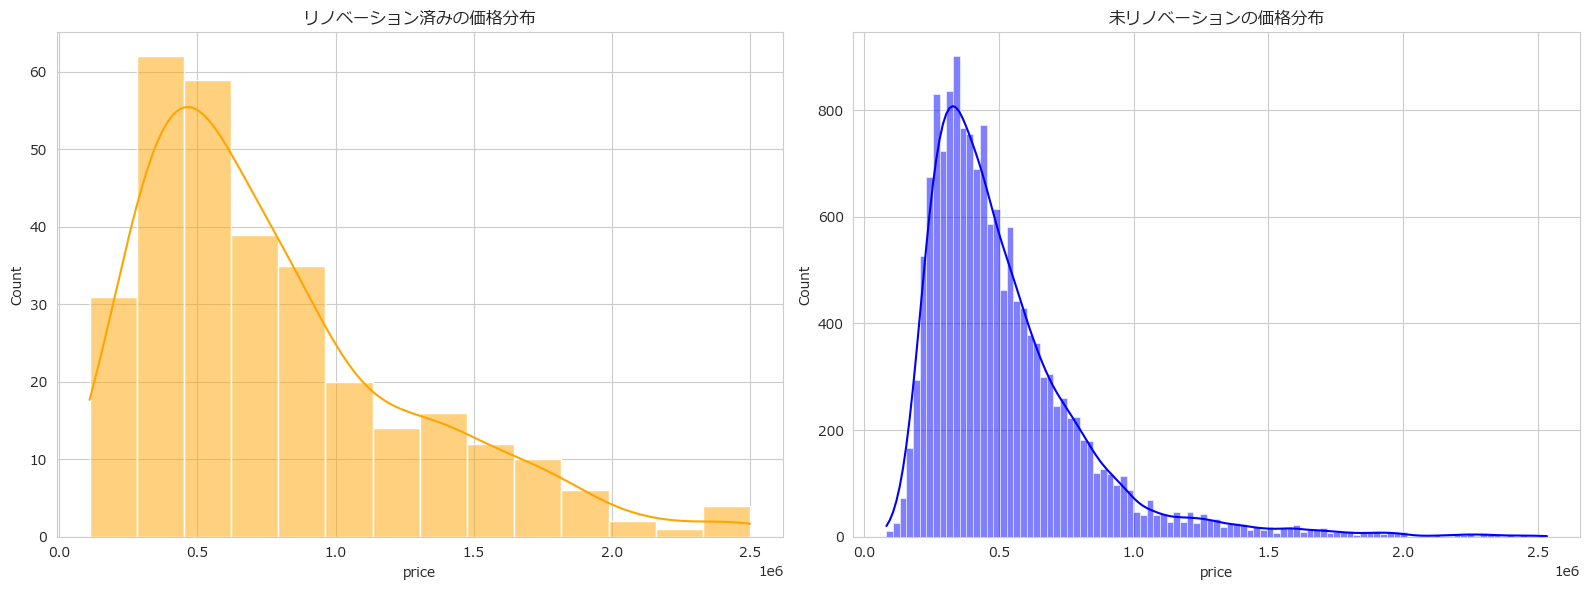

In [30]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 7.7 リノベーションフラグによるデータ特性の違いの確認

# データの確認
print("リノベーションフラグの分布:")
print(data_final['renovated_flag'].value_counts())

# リノベーションフラグのカテゴリ名を設定
renovation_mapping = {0: '未リノベーション', 1: 'リノベーション済み'}
data_final['renovated_flag_cat'] = data_final['renovated_flag'].map(renovation_mapping)

# 価格の分布比較
if 'price' in data_final.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='renovated_flag_cat', y='price', data=data_final, palette='Set2')
    plt.title("リノベーションフラグ別の価格分布", fontsize=16)
    plt.xlabel("リノベーションフラグ", fontsize=14)
    plt.ylabel("価格 (USD)", fontsize=14)
    plt.show()
else:
    print("Error: 'price' column is missing from data_final. Please ensure it is included in the DataFrame.")

# 各リノベーションフラグカテゴリごとの価格の基本統計量
price_stats = data_final.groupby('renovated_flag_cat')['price'].describe().round(2)
price_stats = price_stats.rename(index=renovation_mapping)
print("リノベーションフラグ別の価格統計量:")
display(price_stats)

# その他の主要な数値特徴量の分布比較
numeric_features = ['sqft_lot', 'sqft_living', 'grade', 'age']
feature_jp = {
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'age': '築年数'
}

plt.figure(figsize=(20, 16))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='renovated_flag_cat', y=feature, data=data_final, palette='Set3')
    plt.title(f"リノベーションフラグ別の{feature_jp[feature]}分布", fontsize=14)
    plt.xlabel("リノベーションフラグ", fontsize=12)
    plt.ylabel(feature_jp[feature], fontsize=12)
plt.tight_layout()
plt.show()

# 平均値の比較
mean_values = data_final.groupby('renovated_flag_cat')[numeric_features].mean().round(2)
mean_values = mean_values.rename(index=renovation_mapping)
print("リノベーションフラグ別の主要特徴量の平均値:")
display(mean_values)

# リノベーションフラグ別の相関係数
# 修正: MultiIndexを適切に処理して'price'の相関係数を抽出
corr_result = data_final.groupby('renovated_flag_cat')[['price','sqft_lot','sqft_living','grade','age']].corr()

# 'price' の相関係数を抽出
corr_renovation = corr_result[corr_result.index.get_level_values(1) != 'price'].unstack(level=1)['price'].round(2)

# reset_indexしてカラムを展開
corr_renovation = corr_renovation.reset_index()

# カラム名を具体的かつ適切なものに変更
corr_renovation.columns = ['リノベーションフラグ', '敷地面積との相関係数', '居住スペース面積との相関係数', '建築・デザイン品質評価との相関係数', '築年数との相関係数']

# リノベーションフラグを日本語にマッピング
corr_renovation['リノベーションフラグ'] = corr_renovation['リノベーションフラグ'].map(renovation_mapping)

print("リノベーションフラグ別の価格との相関係数:")
display(corr_renovation)

# リノベーション済み・未リノベーションを分割
df_reno = data_final[data_final['renovated_flag_cat'] == 'リノベーション済み']
df_not_reno = data_final[data_final['renovated_flag_cat'] == '未リノベーション']

# ペアプロットを2つに分けて可視化
sns.pairplot(df_reno, vars=['price', 'sqft_lot', 'sqft_living', 'grade', 'age'], diag_kind='kde')
plt.suptitle("リノベーション済みデータのペアプロット", y=1.02)
plt.show()

sns.pairplot(df_not_reno, vars=['price', 'sqft_lot', 'sqft_living', 'grade', 'age'], diag_kind='kde')
plt.suptitle("未リノベーションデータのペアプロット", y=1.02)
plt.show()

# 価格分布はサブプロットで分けて表示
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False, sharey=False)

sns.histplot(df_reno['price'], ax=axes[0], kde=True, color='orange')
axes[0].set_title("リノベーション済みの価格分布")

sns.histplot(df_not_reno['price'], ax=axes[1], kde=True, color='blue')
axes[1].set_title("未リノベーションの価格分布")

plt.tight_layout()
plt.show()



### 7.7 特徴量間の関係性の可視化

選定した主要特徴量間の関係性をペアプロットや散布図行列で可視化し、複数の特徴量間の相互作用やパターンを確認します。


<Figure size 1500x1500 with 0 Axes>

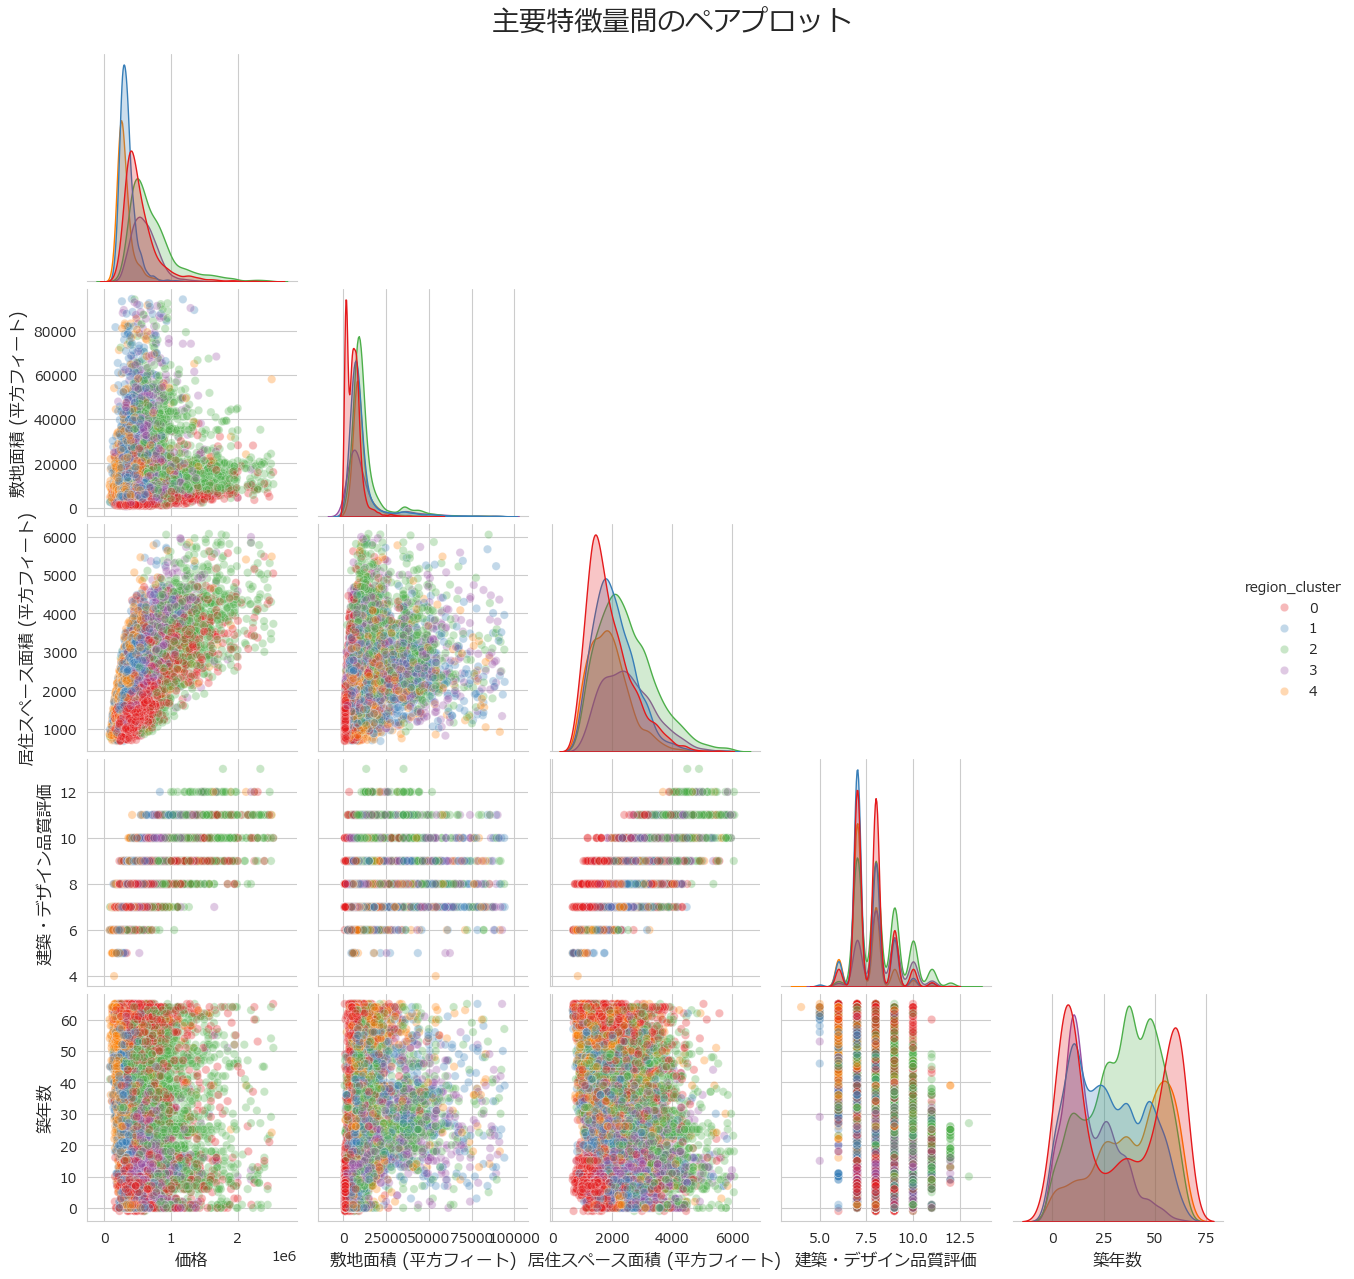

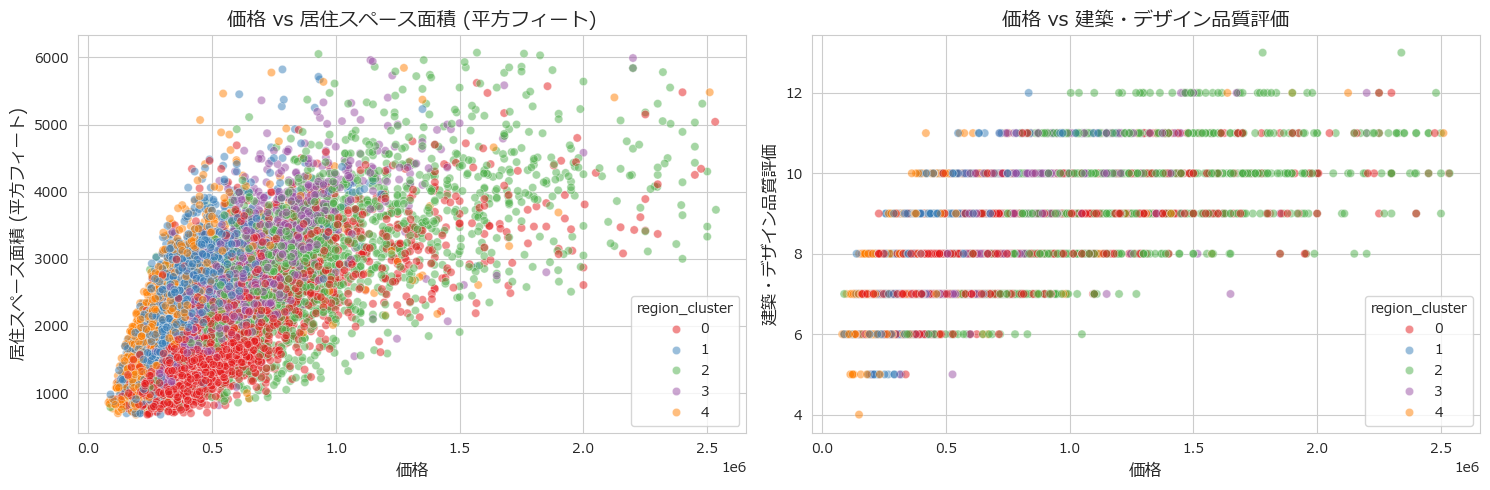

In [18]:
# 7.6 特徴量間の関係性の可視化

import matplotlib.pyplot as plt
import seaborn as sns

# 日本語でのラベル設定用辞書
label_dict = {
    'price': '価格',
    'sqft_lot': '敷地面積 (平方フィート)',
    'sqft_living': '居住スペース面積 (平方フィート)',
    'grade': '建築・デザイン品質評価',
    'age': '築年数',
    'region_cluster': '地域クラスタ'
}

# 主要特徴量のペアプロット
plt.figure(figsize=(15, 15))
pairplot = sns.pairplot(
    data_final,
    vars=['price', 'sqft_lot', 'sqft_living', 'grade', 'age'],
    hue='region_cluster',
    palette='Set1',
    diag_kind='kde',
    markers='o',
    plot_kws={'alpha':0.3},
    corner=True  # 重複するプロットを避けるためにcorner=Trueを設定
)

# ペアプロットの各プロットに日本語ラベルを設定
for ax in pairplot.axes.flatten():
    if ax is not None:
        # x軸ラベル
        xlabel = ax.get_xlabel()
        if xlabel in label_dict:
            ax.set_xlabel(label_dict[xlabel], fontsize=12)
        # y軸ラベル
        ylabel = ax.get_ylabel()
        if ylabel in label_dict:
            ax.set_ylabel(label_dict[ylabel], fontsize=12)

pairplot.fig.suptitle("主要特徴量間のペアプロット", y=1.02, fontsize=20)
plt.show()

# 相関の高いペアを詳細に可視化
high_corr_pairs = [
    ('price', 'sqft_living'),
    ('price', 'grade')
]

plt.figure(figsize=(15, 5))
for i, (x, y) in enumerate(high_corr_pairs, 1):
    plt.subplot(1, len(high_corr_pairs), i)
    sns.scatterplot(
        x=data_final[x],
        y=data_final[y],
        hue=data_final['region_cluster'],
        palette='Set1',
        alpha=0.5
    )
    # タイトルとラベルを日本語に設定
    plt.title(f"{label_dict[x]} vs {label_dict[y]}", fontsize=14)
    plt.xlabel(label_dict[x], fontsize=12)
    plt.ylabel(label_dict[y], fontsize=12)
plt.tight_layout()
plt.show()


## 8. XGBoostによる地域クラスタリングごとの価格予測

本セクションでは、これまでのEDAおよび特徴量エンジニアリングの結果をもとに、XGBoostを用いた価格予測モデルを構築します。特徴的なのは、地域クラスタリングごとにデータの特性の違いがあることが示唆されていたことから、**地域クラスタリング**（`region_cluster`）によってデータを分割し、各地域クラスタごとに別々のモデルを構築・評価する点です。

地域によって不動産価格の分布や市場特性が大きく異なる場合、一括でモデルを作成するよりも、地域別のモデルを作成した方が精度が向上する可能性があります。

以下のステップに沿って実装を進めます。

1. **データの準備 (ステップ8.1)**
2. **地域クラスタ別にデータ分割 (ステップ8.2)**
3. **XGBoostモデルの構築と学習 (ステップ8.3)**
4. **モデルの性能評価 (ステップ8.4)**
5. **比較と考察 (ステップ8.5)**


### 8.1 データの準備

ここでは、XGBoostによる予測を行うために、前処理済みのデータセットを再度確認し、学習に使用する特徴量とターゲット変数を指定します。必要に応じて、対数変換やスケーリングを行います。

- **主な特徴量**: `sqft_lot`, `sqft_living`, `grade`, `lat`, `long`, `yr_built`, `age`, など  
- **ターゲット変数**: `price` (必要ならば `log(price)` を使用)
- **地域クラスタ**: `region_cluster` 列を使用して、データを分割します。


# 8.1 データの準備

import numpy as np
import pandas as pd

# XGBoost関連
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 学習に使用する特徴量（例）
feature_cols = [
    'sqft_lot',
    'sqft_living',
    'grade',
    'lat',
    'long',
    'yr_built',
    'age'
]

# ターゲット変数
target_col = 'price'

# 必要に応じてターゲットの対数変換を行いたい場合は以下を有効化
# data_final[target_col] = np.log1p(data_final[target_col])

# データの簡易確認
print("特徴量サンプル:")
display(data_final[feature_cols].head())
print("ターゲットサンプル:")
display(data_final[target_col].head())

# 地域クラスタの分布確認
print("地域クラスタの分布:")
display(data_final['region_cluster'].value_counts())
